# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Наши данные: технические характеристики, комплектации и цены автомобилей. 
Задача: построить модель для определения стоимости автомобиля. 

Важные факторы:
- качество предсказания;
- скорость предсказания;
- время обучения.
- RMSE не более 1850

In [1]:
%matplotlib inline
import time
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from ydata_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import tqdm as notebook_tqdm

In [2]:
try:
    raw_data = pd.read_csv('/datasets/autos.csv')
except:
    raw_data = pd.read_csv('./datasets/autos.csv')

## Подготовка данных

<b> Общий обзор

In [3]:
raw_data.head(4)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17


In [ ]:
ProfileReport(raw_data, title = "Сводка по Таблице")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<b> Удаление дубликатов.

In [5]:
raw_data= raw_data.drop_duplicates()
raw_data.duplicated().sum()

0

<b> Признаки наличия фото, даты скачивания анкеты, активность пользователя нам не интересны, исключим их датасета. А вот дата создания анкеты имеет важный признак, так как цена устанавливалась на момент подачи объявления, это показатель текущего рынка ценообразования.

In [6]:
data = raw_data.drop(['NumberOfPictures', 'DateCrawled', 'LastSeen'], axis = 1)
data.head(2)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354365 non-null  int64 
 1   VehicleType        316875 non-null  object
 2   RegistrationYear   354365 non-null  int64 
 3   Gearbox            334532 non-null  object
 4   Power              354365 non-null  int64 
 5   Model              334660 non-null  object
 6   Kilometer          354365 non-null  int64 
 7   RegistrationMonth  354365 non-null  int64 
 8   FuelType           321470 non-null  object
 9   Brand              354365 non-null  object
 10  Repaired           283211 non-null  object
 11  DateCreated        354365 non-null  object
 12  PostalCode         354365 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 37.9+ MB


In [8]:
data.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
PostalCode               0
dtype: int64

<b> Nan в данных о ремонте приравням к отсутсвию ремонта, заменим все на 1 и 0

In [9]:
data['Repaired'] = data['Repaired'].replace(['yes', 'no'], [1,0]).fillna(0)

In [10]:
data['Repaired'].unique()

array([0., 1.])

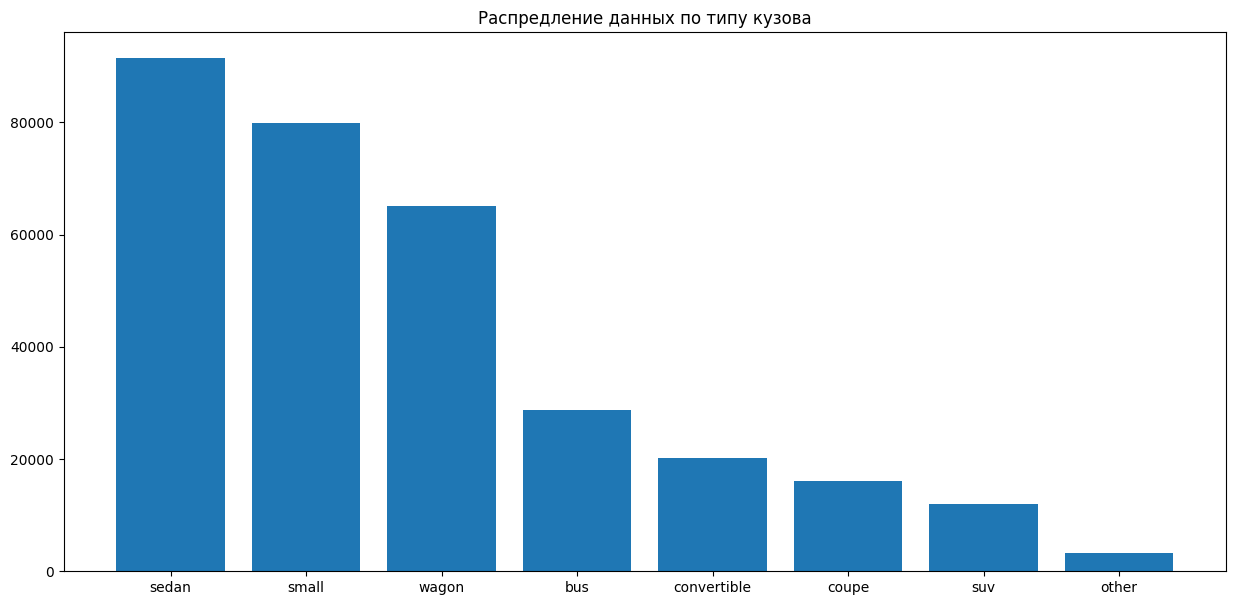

In [11]:
plt.figure(figsize=(15, 7))
plt.bar(height = data['VehicleType'].value_counts(), x = list (data['VehicleType'].value_counts().index))
plt.title('Распредление данных по типу кузова')
plt.show()

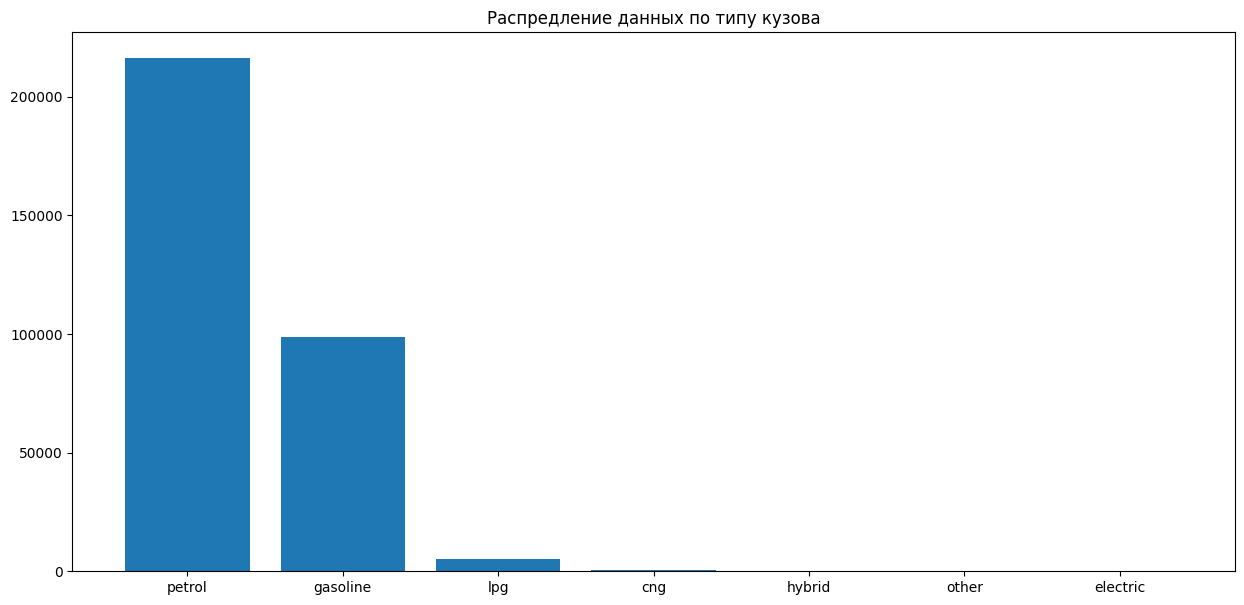

In [12]:
data['FuelType'].value_counts()
plt.figure(figsize=(15, 7))
plt.bar(height = data['FuelType'].value_counts(), x = list (data['FuelType'].value_counts().index))
plt.title('Распредление данных по типу кузова')
plt.show()

In [13]:
data['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [14]:
data['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Есть два типа трансимиссий в датасете: автоматический и ручной тип. Вероятно, что клиенты не указывали тип в связи с тем, что у них роботизированнный либо , например, вариаторный тип. Для авто это важный момент.

<b> Приравняем все пропущенные данные к категории other. Так как мы не можем утверждать, почему и как появились пропуски. Выдвинем версию, что нужных данных для выбора не было в списке предлагаемых интрефейсом.

In [15]:
data['VehicleType'] = data['VehicleType'].fillna('other')
data['FuelType'] = data['FuelType'].fillna('other')
data['Gearbox'] = data['Gearbox'].fillna('other')
data['Model'] = data['Model'].fillna('other')

In [16]:
data.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
PostalCode           0
dtype: int64

In [17]:
data.sample(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode
166924,1100,small,2001,manual,52,twingo,150000,1,petrol,renault,0.0,2016-03-11 00:00:00,45147
183444,1000,small,1999,manual,101,golf,150000,10,petrol,volkswagen,0.0,2016-03-20 00:00:00,39249
187966,1250,small,2000,manual,60,punto,60000,1,petrol,fiat,0.0,2016-03-29 00:00:00,22525
319278,2000,sedan,2000,manual,101,a3,150000,5,petrol,audi,0.0,2016-04-04 00:00:00,60323
149705,2100,wagon,2000,manual,115,golf,150000,10,petrol,volkswagen,0.0,2016-03-24 00:00:00,94513
288487,300,small,2000,other,0,twingo,150000,3,petrol,renault,0.0,2016-03-18 00:00:00,69509
75038,6400,wagon,2003,manual,131,a4,150000,12,gasoline,audi,0.0,2016-03-07 00:00:00,97243
212337,1000,suv,1987,manual,45,other,80000,0,petrol,suzuki,0.0,2016-04-03 00:00:00,18292
212698,11999,suv,2009,auto,140,tiguan,150000,11,gasoline,volkswagen,0.0,2016-03-16 00:00:00,17192
83911,15600,bus,2012,manual,163,other,30000,4,gasoline,fiat,0.0,2016-03-19 00:00:00,85521


## Обучение моделей

<b> Разделение датасета на выборки

In [18]:
test_data = data.sample(int(data.shape[0]/3))

In [19]:
test_futures = test_data.drop(['Price'], axis=1)
test_futures.sample()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode
256710,small,1999,manual,44,polo,150000,10,petrol,volkswagen,0.0,2016-03-22 00:00:00,64347


In [20]:
test_target = test_data['Price']

In [21]:
data_train = data.drop(test_data.index)

In [22]:
future_train, future_valid, target_train, target_valid = train_test_split(
    data_train.drop(['Price'], axis=1),
    data_train["Price"],
    test_size = 0.2
)

In [23]:
future_train.shape[0]/future_valid.shape[0]

3.9999788355309107

In [24]:
future_train.sample(1)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode
66519,other,2017,manual,101,zafira,150000,0,petrol,opel,0.0,2016-03-08 00:00:00,35510


In [25]:
label_col = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']
future_train[label_col]

,VehicleType,Gearbox,Model,FuelType,Brand
116046,wagon,manual,other,petrol,mercedes_benz
61952,coupe,other,2_reihe,petrol,peugeot
47281,convertible,other,golf,petrol,volkswagen
186675,sedan,manual,3er,petrol,bmw
119230,small,manual,fortwo,petrol,smart
...,...,...,...,...,...
171117,sedan,manual,passat,petrol,volkswagen
95090,small,manual,corsa,petrol,opel
57102,sedan,manual,astra,petrol,opel
190795,convertible,manual,golf,petrol,volkswagen


<b> Преобразуем категориальные данные в числа с помощью LabelEncoder

In [26]:
data.sample(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode
66787,4300,small,2006,manual,70,fiesta,70000,3,petrol,ford,0.0,2016-03-03 00:00:00,69429
21953,2100,small,2001,manual,60,2_reihe,125000,3,petrol,peugeot,0.0,2016-03-31 00:00:00,27299
113184,350,small,1995,manual,5575,polo,150000,1,petrol,volkswagen,1.0,2016-03-12 00:00:00,29664
67341,1950,other,2017,auto,101,other,150000,0,other,audi,0.0,2016-04-04 00:00:00,50354
55664,2600,small,2004,manual,69,fiesta,150000,10,petrol,ford,0.0,2016-03-20 00:00:00,40882


In [27]:
encode_dict = {}
for itter in label_col:
    label_encoder =  LabelEncoder()
    encode_dict[itter] = (label_encoder.fit(future_train[itter]))


In [28]:
#На каждый признак свой LabelEncoder
encode_dict

{'VehicleType': LabelEncoder(),
 'Gearbox': LabelEncoder(),
 'Model': LabelEncoder(),
 'FuelType': LabelEncoder(),
 'Brand': LabelEncoder()}

In [29]:
#Трансформация признаков на основании обученных LsbelEncoder
def dataset_transform (dataset, label_col):
    for itter in label_col:
        dataset[itter] = encode_dict[itter].transform(dataset[itter])
    dataset['DateCreated'] = dataset['DateCreated'].apply(lambda rows: time.mktime(pd.Timestamp(rows).timetuple()))
    return dataset

In [30]:
future_train = dataset_transform(future_train, label_col)

In [31]:
future_train.sample(20)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode
76492,4,2006,0,0,194,150000,0,5,13,0.0,1.457125e+09,85057
134686,5,2009,1,95,166,80000,6,6,9,1.0,1.457298e+09,91275
307190,4,2005,2,0,124,150000,9,2,38,0.0,1.457903e+09,21514
37377,1,1973,1,0,166,20000,4,6,27,1.0,1.458767e+09,24149
149883,4,1998,1,125,29,150000,3,6,1,0.0,1.458248e+09,51545
202817,4,2000,1,0,34,150000,0,6,11,0.0,1.459112e+09,59425
284335,7,2005,1,140,29,150000,3,5,1,0.0,1.457730e+09,56472
261866,4,2004,1,140,28,150000,4,2,1,0.0,1.459112e+09,53940
7842,7,2001,1,109,50,150000,11,6,5,1.0,1.457125e+09,56237
14598,1,1998,1,150,116,150000,6,6,38,0.0,1.459717e+09,99867


In [32]:
numeric_col = ['RegistrationYear', 'Power', 'Kilometer', 'DateCreated']

In [33]:
future_train[numeric_col]

,RegistrationYear,Power,Kilometer,DateCreated
116046,1992,132,150000,1.459199e+09
61952,2005,0,5000,1.457816e+09
47281,2001,116,150000,1.457298e+09
186675,2006,218,150000,1.459631e+09
119230,2004,61,90000,1.458680e+09
...,...,...,...,...
171117,2000,101,150000,1.457125e+09
95090,2003,58,150000,1.459544e+09
57102,2009,116,125000,1.458680e+09
190795,1993,72,150000,1.457125e+09


In [34]:
scaler = StandardScaler()
scaler.fit(future_train[numeric_col])
future_train[numeric_col] = pd.DataFrame(scaler.transform(future_train[numeric_col]), columns=numeric_col, index=future_train.index)

In [35]:
future_train

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode
116046,7,-0.130381,1,0.121431,166,0.574280,8,6,20,0.0,0.883563,82335
61952,2,0.007251,2,-0.604264,8,-3.256699,7,6,25,0.0,-0.842390,63739
47281,1,-0.035098,2,0.033468,116,0.574280,7,6,38,0.0,-1.489622,91785
186675,4,0.017838,1,0.594233,11,0.574280,3,6,2,0.0,1.422923,54687
119230,5,-0.003336,1,-0.268905,106,-1.010953,7,6,32,0.0,0.236330,44359
...,...,...,...,...,...,...,...,...,...,...,...,...
171117,4,-0.045685,1,-0.048997,170,0.574280,4,6,38,1.0,-1.705366,35756
95090,5,-0.013923,1,-0.285398,83,0.574280,6,6,24,0.0,1.315051,97762
57102,4,0.049599,1,0.033468,42,-0.086234,9,6,24,0.0,0.236330,44339
190795,1,-0.119794,1,-0.208430,116,0.574280,5,6,38,1.0,-1.705366,26689


<b> Трансформация валидационной выборки.

In [36]:
future_valid = dataset_transform(
    future_valid,
    label_col)

In [37]:
future_valid.sample()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode
5030,5,1998,1,0,166,150000,0,5,38,0.0,1.457730e+09,19246


In [38]:
future_valid[numeric_col] = pd.DataFrame(scaler.transform(future_valid[numeric_col]), columns=numeric_col, index=future_valid.index)

In [39]:
future_valid

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode
333412,1,-0.035098,0,0.456791,61,0.574280,1,6,39,0.0,-0.195158,30900
31935,5,-0.098620,1,-0.604264,102,0.574280,3,6,10,0.0,-0.626646,29358
352695,4,0.039012,1,0.495274,116,0.574280,0,6,38,0.0,0.667819,83022
58454,4,0.113122,1,-0.048997,119,-2.860391,5,6,12,0.0,0.020586,25554
317780,7,0.070773,1,-0.131462,120,-1.803569,9,6,30,0.0,-0.087286,64293
...,...,...,...,...,...,...,...,...,...,...,...,...
20233,3,0.007251,1,0.082948,166,-0.086234,5,5,24,0.0,0.991435,58706
177190,5,-0.066859,1,-0.362366,176,0.574280,1,6,9,0.0,-1.705366,88326
221086,0,0.028425,0,0.165413,222,0.574280,9,2,38,0.0,-0.950262,26919
345868,4,-0.066859,1,0.033468,42,0.574280,9,6,24,0.0,-1.273878,88410


In [40]:
dataset_transform(test_futures, label_col)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode
76975,5,1999,1,60,143,150000,4,2,38,0.0,1.457730e+09,21149
320446,3,2016,1,0,143,150000,5,6,38,0.0,1.459199e+09,35435
237014,7,2008,0,140,154,150000,9,2,10,0.0,1.458508e+09,26197
217524,4,2011,1,90,119,125000,5,2,12,0.0,1.458680e+09,48683
165034,5,1997,1,54,75,125000,7,6,27,0.0,1.458767e+09,23966
...,...,...,...,...,...,...,...,...,...,...,...,...
48989,7,1999,1,136,164,150000,7,6,24,0.0,1.458076e+09,15898
74162,5,2002,1,82,75,150000,6,2,27,0.0,1.457903e+09,65520
182460,3,2017,2,75,116,150000,1,6,38,0.0,1.457384e+09,27283
351967,5,2002,1,68,102,150000,11,2,10,0.0,1.459026e+09,12353


In [41]:
test_futures.sample()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode
4768,0,2003,1,75,79,150000,6,2,24,0.0,1.457384e+09,93059


In [42]:
test_futures[numeric_col] = pd.DataFrame(scaler.transform(test_futures[numeric_col]), columns=numeric_col, index=test_futures.index)

In [43]:
test_futures

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode
76975,5,-0.056272,1,-0.274402,143,0.574280,4,2,38,0.0,-0.950262,21149
320446,3,0.123709,1,-0.604264,143,0.574280,5,6,38,0.0,0.883563,35435
237014,7,0.039012,0,0.165413,154,0.574280,9,2,10,0.0,0.020586,26197
217524,4,0.070773,1,-0.109472,119,-0.086234,5,2,12,0.0,0.236330,48683
165034,5,-0.077446,1,-0.307389,75,-0.086234,7,6,27,0.0,0.344202,23966
...,...,...,...,...,...,...,...,...,...,...,...,...
48989,7,-0.056272,1,0.143422,164,0.574280,7,6,24,0.0,-0.518774,15898
74162,5,-0.024511,1,-0.153453,75,0.574280,6,2,27,0.0,-0.734518,65520
182460,3,0.134296,2,-0.191937,116,0.574280,1,6,38,0.0,-1.381750,27283
351967,5,-0.024511,1,-0.230421,102,0.574280,11,2,10,0.0,0.667819,12353


## Анализ моделей

### Линейная регрессия

In [44]:
model_linear = LinearRegression ()

In [45]:
%%time
model_linear.fit(future_train, target_train)
predict_l = model_linear.predict(future_valid)

CPU times: total: 234 ms
Wall time: 364 ms


In [46]:
mean_squared_error(target_valid, predict_l)**0.5

3671.462834617793

In [47]:
r2_score(target_valid, predict_l)

0.3353637267254026

### CatBoost

In [48]:
%%time
grid = {'learning_rate': [0.5],
        'depth': [10, 12],
        'iterations': [1500]}
model_cat = CatBoostRegressor()
model_cat.grid_search(grid, future_train, target_train, plot=False)

0:	learn: 3841.1596668	test: 3836.4476556	best: 3836.4476556 (0)	total: 319ms	remaining: 7m 57s
1:	learn: 2782.4448866	test: 2783.3329470	best: 2783.3329470 (1)	total: 410ms	remaining: 5m 7s
2:	learn: 2371.0328505	test: 2381.1629931	best: 2381.1629931 (2)	total: 511ms	remaining: 4m 15s
3:	learn: 2185.9074839	test: 2199.7471426	best: 2199.7471426 (3)	total: 632ms	remaining: 3m 56s
4:	learn: 2096.5344532	test: 2115.3843046	best: 2115.3843046 (4)	total: 725ms	remaining: 3m 36s
5:	learn: 2050.5074544	test: 2069.5455478	best: 2069.5455478 (5)	total: 842ms	remaining: 3m 29s
6:	learn: 2010.6474842	test: 2031.2106875	best: 2031.2106875 (6)	total: 986ms	remaining: 3m 30s
7:	learn: 1979.1405654	test: 2003.4587461	best: 2003.4587461 (7)	total: 1.1s	remaining: 3m 24s
8:	learn: 1961.0917566	test: 1986.8378211	best: 1986.8378211 (8)	total: 1.2s	remaining: 3m 18s
9:	learn: 1942.2043473	test: 1974.7832714	best: 1974.7832714 (9)	total: 1.3s	remaining: 3m 13s
10:	learn: 1924.8360706	test: 1965.7307033	b

86:	learn: 1551.8792733	test: 1813.2294824	best: 1812.9117519 (85)	total: 10.2s	remaining: 2m 46s
87:	learn: 1548.0687944	test: 1812.1024491	best: 1812.1024491 (87)	total: 10.3s	remaining: 2m 45s
88:	learn: 1545.8790457	test: 1811.2101410	best: 1811.2101410 (88)	total: 10.4s	remaining: 2m 45s
89:	learn: 1544.4540282	test: 1811.9417795	best: 1811.2101410 (88)	total: 10.5s	remaining: 2m 44s
90:	learn: 1543.0353327	test: 1812.1791834	best: 1811.2101410 (88)	total: 10.6s	remaining: 2m 44s
91:	learn: 1541.2191213	test: 1812.4600526	best: 1811.2101410 (88)	total: 10.7s	remaining: 2m 43s
92:	learn: 1538.1153590	test: 1813.7708454	best: 1811.2101410 (88)	total: 10.8s	remaining: 2m 43s
93:	learn: 1536.8747312	test: 1813.9453820	best: 1811.2101410 (88)	total: 10.9s	remaining: 2m 42s
94:	learn: 1535.1746546	test: 1814.0392071	best: 1811.2101410 (88)	total: 11s	remaining: 2m 42s
95:	learn: 1532.3093132	test: 1813.5959741	best: 1811.2101410 (88)	total: 11.1s	remaining: 2m 42s
96:	learn: 1529.830087

169:	learn: 1392.2283405	test: 1805.8062679	best: 1805.7892343 (168)	total: 19.1s	remaining: 2m 29s
170:	learn: 1390.3514540	test: 1805.5253228	best: 1805.5253228 (170)	total: 19.2s	remaining: 2m 29s
171:	learn: 1389.4963650	test: 1805.2758667	best: 1805.2758667 (171)	total: 19.3s	remaining: 2m 28s
172:	learn: 1387.7860976	test: 1805.5647966	best: 1805.2758667 (171)	total: 19.4s	remaining: 2m 28s
173:	learn: 1385.8015922	test: 1805.5940331	best: 1805.2758667 (171)	total: 19.5s	remaining: 2m 28s
174:	learn: 1385.1553361	test: 1805.6393028	best: 1805.2758667 (171)	total: 19.7s	remaining: 2m 29s
175:	learn: 1382.4249302	test: 1805.7396965	best: 1805.2758667 (171)	total: 19.9s	remaining: 2m 29s
176:	learn: 1380.3998474	test: 1806.0963369	best: 1805.2758667 (171)	total: 20s	remaining: 2m 29s
177:	learn: 1379.4775064	test: 1806.2042864	best: 1805.2758667 (171)	total: 20.1s	remaining: 2m 29s
178:	learn: 1378.1019059	test: 1805.7194104	best: 1805.2758667 (171)	total: 20.3s	remaining: 2m 29s
17

253:	learn: 1276.9590781	test: 1808.8073259	best: 1803.7030871 (217)	total: 28.6s	remaining: 2m 20s
254:	learn: 1275.6488437	test: 1808.5385304	best: 1803.7030871 (217)	total: 28.7s	remaining: 2m 20s
255:	learn: 1274.0491932	test: 1808.5553063	best: 1803.7030871 (217)	total: 28.8s	remaining: 2m 20s
256:	learn: 1272.6372225	test: 1808.3055598	best: 1803.7030871 (217)	total: 28.9s	remaining: 2m 19s
257:	learn: 1271.2732473	test: 1808.3277710	best: 1803.7030871 (217)	total: 29s	remaining: 2m 19s
258:	learn: 1270.7946727	test: 1808.5268270	best: 1803.7030871 (217)	total: 29.1s	remaining: 2m 19s
259:	learn: 1269.3392441	test: 1808.8405478	best: 1803.7030871 (217)	total: 29.2s	remaining: 2m 19s
260:	learn: 1268.7426762	test: 1808.6371247	best: 1803.7030871 (217)	total: 29.3s	remaining: 2m 19s
261:	learn: 1267.9583956	test: 1808.3316565	best: 1803.7030871 (217)	total: 29.4s	remaining: 2m 18s
262:	learn: 1267.2467243	test: 1808.7439956	best: 1803.7030871 (217)	total: 29.5s	remaining: 2m 18s
26

336:	learn: 1187.9251771	test: 1809.8105859	best: 1803.7030871 (217)	total: 37s	remaining: 2m 7s
337:	learn: 1187.0113730	test: 1810.1028369	best: 1803.7030871 (217)	total: 37.1s	remaining: 2m 7s
338:	learn: 1185.9553868	test: 1810.0853829	best: 1803.7030871 (217)	total: 37.2s	remaining: 2m 7s
339:	learn: 1184.9651379	test: 1810.4641741	best: 1803.7030871 (217)	total: 37.4s	remaining: 2m 7s
340:	learn: 1183.9101208	test: 1811.0024947	best: 1803.7030871 (217)	total: 37.4s	remaining: 2m 7s
341:	learn: 1183.4399069	test: 1811.0255285	best: 1803.7030871 (217)	total: 37.5s	remaining: 2m 7s
342:	learn: 1182.8788302	test: 1810.9434211	best: 1803.7030871 (217)	total: 37.6s	remaining: 2m 6s
343:	learn: 1181.9654223	test: 1810.8627662	best: 1803.7030871 (217)	total: 37.7s	remaining: 2m 6s
344:	learn: 1180.8223232	test: 1810.6340308	best: 1803.7030871 (217)	total: 37.8s	remaining: 2m 6s
345:	learn: 1179.4726739	test: 1810.6844872	best: 1803.7030871 (217)	total: 37.9s	remaining: 2m 6s
346:	learn: 

421:	learn: 1112.9393919	test: 1812.8688656	best: 1803.7030871 (217)	total: 45.6s	remaining: 1m 56s
422:	learn: 1111.4584701	test: 1813.4268613	best: 1803.7030871 (217)	total: 45.7s	remaining: 1m 56s
423:	learn: 1110.4660256	test: 1813.2033974	best: 1803.7030871 (217)	total: 45.8s	remaining: 1m 56s
424:	learn: 1109.8567822	test: 1813.2169087	best: 1803.7030871 (217)	total: 45.9s	remaining: 1m 56s
425:	learn: 1108.8201948	test: 1813.1615558	best: 1803.7030871 (217)	total: 46s	remaining: 1m 55s
426:	learn: 1108.2225045	test: 1813.2671083	best: 1803.7030871 (217)	total: 46.1s	remaining: 1m 55s
427:	learn: 1107.4007424	test: 1813.1117939	best: 1803.7030871 (217)	total: 46.2s	remaining: 1m 55s
428:	learn: 1106.4072494	test: 1812.8831396	best: 1803.7030871 (217)	total: 46.3s	remaining: 1m 55s
429:	learn: 1105.5768273	test: 1812.7273313	best: 1803.7030871 (217)	total: 46.4s	remaining: 1m 55s
430:	learn: 1104.9574196	test: 1812.3856507	best: 1803.7030871 (217)	total: 46.5s	remaining: 1m 55s
43

504:	learn: 1051.0115857	test: 1814.9150041	best: 1803.7030871 (217)	total: 54.5s	remaining: 1m 47s
505:	learn: 1050.1435433	test: 1815.0968698	best: 1803.7030871 (217)	total: 54.6s	remaining: 1m 47s
506:	learn: 1050.0555102	test: 1815.1381133	best: 1803.7030871 (217)	total: 54.7s	remaining: 1m 47s
507:	learn: 1049.2012640	test: 1815.5211163	best: 1803.7030871 (217)	total: 54.8s	remaining: 1m 46s
508:	learn: 1047.8022762	test: 1815.7137218	best: 1803.7030871 (217)	total: 54.9s	remaining: 1m 46s
509:	learn: 1047.1987045	test: 1816.0398924	best: 1803.7030871 (217)	total: 55s	remaining: 1m 46s
510:	learn: 1046.7134783	test: 1815.8797824	best: 1803.7030871 (217)	total: 55.1s	remaining: 1m 46s
511:	learn: 1046.3793900	test: 1815.8939511	best: 1803.7030871 (217)	total: 55.2s	remaining: 1m 46s
512:	learn: 1045.5889117	test: 1815.9680252	best: 1803.7030871 (217)	total: 55.3s	remaining: 1m 46s
513:	learn: 1045.4535334	test: 1816.0515359	best: 1803.7030871 (217)	total: 55.4s	remaining: 1m 46s
51

587:	learn: 996.0764101	test: 1818.3592881	best: 1803.7030871 (217)	total: 1m 3s	remaining: 1m 38s
588:	learn: 995.4918126	test: 1818.2046951	best: 1803.7030871 (217)	total: 1m 3s	remaining: 1m 38s
589:	learn: 994.8060343	test: 1818.4079277	best: 1803.7030871 (217)	total: 1m 3s	remaining: 1m 38s
590:	learn: 994.2657495	test: 1818.3491386	best: 1803.7030871 (217)	total: 1m 3s	remaining: 1m 38s
591:	learn: 993.5548920	test: 1818.2382514	best: 1803.7030871 (217)	total: 1m 4s	remaining: 1m 38s
592:	learn: 993.0088979	test: 1818.3450941	best: 1803.7030871 (217)	total: 1m 4s	remaining: 1m 38s
593:	learn: 992.3416893	test: 1818.5042441	best: 1803.7030871 (217)	total: 1m 4s	remaining: 1m 38s
594:	learn: 991.7806174	test: 1818.5143452	best: 1803.7030871 (217)	total: 1m 4s	remaining: 1m 38s
595:	learn: 991.2656415	test: 1818.4468128	best: 1803.7030871 (217)	total: 1m 4s	remaining: 1m 37s
596:	learn: 990.6796553	test: 1818.5259396	best: 1803.7030871 (217)	total: 1m 4s	remaining: 1m 37s
597:	learn

671:	learn: 950.4431328	test: 1821.3625379	best: 1803.7030871 (217)	total: 1m 12s	remaining: 1m 29s
672:	learn: 950.1474232	test: 1821.4471322	best: 1803.7030871 (217)	total: 1m 12s	remaining: 1m 29s
673:	learn: 949.4579904	test: 1821.5579600	best: 1803.7030871 (217)	total: 1m 12s	remaining: 1m 29s
674:	learn: 948.9863465	test: 1821.5978224	best: 1803.7030871 (217)	total: 1m 12s	remaining: 1m 29s
675:	learn: 948.4176210	test: 1821.6885806	best: 1803.7030871 (217)	total: 1m 13s	remaining: 1m 29s
676:	learn: 947.9759643	test: 1821.8222078	best: 1803.7030871 (217)	total: 1m 13s	remaining: 1m 28s
677:	learn: 947.5722675	test: 1821.7367550	best: 1803.7030871 (217)	total: 1m 13s	remaining: 1m 28s
678:	learn: 947.3865104	test: 1821.9511251	best: 1803.7030871 (217)	total: 1m 13s	remaining: 1m 28s
679:	learn: 946.7619363	test: 1822.2793144	best: 1803.7030871 (217)	total: 1m 13s	remaining: 1m 28s
680:	learn: 946.2823210	test: 1822.2607791	best: 1803.7030871 (217)	total: 1m 13s	remaining: 1m 28s


754:	learn: 911.3067559	test: 1824.9030099	best: 1803.7030871 (217)	total: 1m 21s	remaining: 1m 20s
755:	learn: 910.6789607	test: 1825.3402451	best: 1803.7030871 (217)	total: 1m 21s	remaining: 1m 20s
756:	learn: 910.2128063	test: 1825.4430284	best: 1803.7030871 (217)	total: 1m 21s	remaining: 1m 20s
757:	learn: 909.4370917	test: 1825.6815964	best: 1803.7030871 (217)	total: 1m 21s	remaining: 1m 20s
758:	learn: 908.9461612	test: 1825.7132967	best: 1803.7030871 (217)	total: 1m 21s	remaining: 1m 20s
759:	learn: 908.1411550	test: 1825.5913106	best: 1803.7030871 (217)	total: 1m 22s	remaining: 1m 19s
760:	learn: 907.2524277	test: 1825.6792684	best: 1803.7030871 (217)	total: 1m 22s	remaining: 1m 19s
761:	learn: 906.7823308	test: 1825.6756876	best: 1803.7030871 (217)	total: 1m 22s	remaining: 1m 19s
762:	learn: 906.3471038	test: 1825.6021306	best: 1803.7030871 (217)	total: 1m 22s	remaining: 1m 19s
763:	learn: 905.5884542	test: 1825.5582912	best: 1803.7030871 (217)	total: 1m 22s	remaining: 1m 19s


837:	learn: 872.9314038	test: 1827.3034924	best: 1803.7030871 (217)	total: 1m 30s	remaining: 1m 11s
838:	learn: 872.5656663	test: 1827.1408214	best: 1803.7030871 (217)	total: 1m 30s	remaining: 1m 11s
839:	learn: 872.2408405	test: 1827.0894561	best: 1803.7030871 (217)	total: 1m 30s	remaining: 1m 11s
840:	learn: 871.6605916	test: 1827.1338156	best: 1803.7030871 (217)	total: 1m 30s	remaining: 1m 11s
841:	learn: 871.2846962	test: 1827.0796899	best: 1803.7030871 (217)	total: 1m 30s	remaining: 1m 11s
842:	learn: 870.7524265	test: 1827.1951089	best: 1803.7030871 (217)	total: 1m 31s	remaining: 1m 11s
843:	learn: 870.3775684	test: 1827.1072056	best: 1803.7030871 (217)	total: 1m 31s	remaining: 1m 10s
844:	learn: 869.8405222	test: 1827.1166055	best: 1803.7030871 (217)	total: 1m 31s	remaining: 1m 10s
845:	learn: 869.3876726	test: 1827.1764384	best: 1803.7030871 (217)	total: 1m 31s	remaining: 1m 10s
846:	learn: 868.9790248	test: 1827.2350001	best: 1803.7030871 (217)	total: 1m 31s	remaining: 1m 10s


921:	learn: 836.9566396	test: 1830.9955358	best: 1803.7030871 (217)	total: 1m 40s	remaining: 1m 3s
922:	learn: 836.3813821	test: 1831.2259194	best: 1803.7030871 (217)	total: 1m 40s	remaining: 1m 3s
923:	learn: 836.1001053	test: 1831.3355148	best: 1803.7030871 (217)	total: 1m 40s	remaining: 1m 2s
924:	learn: 835.9184834	test: 1831.3992537	best: 1803.7030871 (217)	total: 1m 41s	remaining: 1m 2s
925:	learn: 835.5821571	test: 1831.5154332	best: 1803.7030871 (217)	total: 1m 41s	remaining: 1m 2s
926:	learn: 834.7901600	test: 1831.4227235	best: 1803.7030871 (217)	total: 1m 41s	remaining: 1m 2s
927:	learn: 834.3352279	test: 1831.2225667	best: 1803.7030871 (217)	total: 1m 41s	remaining: 1m 2s
928:	learn: 833.9850178	test: 1831.3421258	best: 1803.7030871 (217)	total: 1m 41s	remaining: 1m 2s
929:	learn: 833.6458871	test: 1831.2542867	best: 1803.7030871 (217)	total: 1m 41s	remaining: 1m 2s
930:	learn: 833.1352564	test: 1830.9471471	best: 1803.7030871 (217)	total: 1m 41s	remaining: 1m 2s
931:	learn

1006:	learn: 802.4228914	test: 1833.4602449	best: 1803.7030871 (217)	total: 1m 50s	remaining: 54.2s
1007:	learn: 801.9112435	test: 1833.3689797	best: 1803.7030871 (217)	total: 1m 50s	remaining: 54.1s
1008:	learn: 801.2885267	test: 1833.2876973	best: 1803.7030871 (217)	total: 1m 50s	remaining: 54s
1009:	learn: 800.8929797	test: 1833.1897821	best: 1803.7030871 (217)	total: 1m 51s	remaining: 53.9s
1010:	learn: 800.5023293	test: 1833.1975217	best: 1803.7030871 (217)	total: 1m 51s	remaining: 53.8s
1011:	learn: 800.0876432	test: 1833.3454551	best: 1803.7030871 (217)	total: 1m 51s	remaining: 53.6s
1012:	learn: 799.8767177	test: 1833.3743740	best: 1803.7030871 (217)	total: 1m 51s	remaining: 53.5s
1013:	learn: 799.5869641	test: 1833.4872030	best: 1803.7030871 (217)	total: 1m 51s	remaining: 53.4s
1014:	learn: 799.3278955	test: 1833.5358184	best: 1803.7030871 (217)	total: 1m 51s	remaining: 53.3s
1015:	learn: 798.8310099	test: 1833.6660633	best: 1803.7030871 (217)	total: 1m 51s	remaining: 53.2s
10

1090:	learn: 773.6433795	test: 1836.2564069	best: 1803.7030871 (217)	total: 2m 1s	remaining: 45.4s
1091:	learn: 772.8830967	test: 1836.4297882	best: 1803.7030871 (217)	total: 2m 1s	remaining: 45.3s
1092:	learn: 772.4928405	test: 1836.4777964	best: 1803.7030871 (217)	total: 2m 1s	remaining: 45.2s
1093:	learn: 772.0521428	test: 1836.5806060	best: 1803.7030871 (217)	total: 2m 1s	remaining: 45.1s
1094:	learn: 771.7672334	test: 1836.5938855	best: 1803.7030871 (217)	total: 2m 1s	remaining: 45s
1095:	learn: 771.4986811	test: 1836.6305827	best: 1803.7030871 (217)	total: 2m 1s	remaining: 44.9s
1096:	learn: 771.2208414	test: 1836.6742086	best: 1803.7030871 (217)	total: 2m 1s	remaining: 44.8s
1097:	learn: 770.8440221	test: 1836.5402875	best: 1803.7030871 (217)	total: 2m 2s	remaining: 44.7s
1098:	learn: 770.6365329	test: 1836.4586207	best: 1803.7030871 (217)	total: 2m 2s	remaining: 44.6s
1099:	learn: 770.3298631	test: 1836.4304027	best: 1803.7030871 (217)	total: 2m 2s	remaining: 44.5s
1100:	learn:

1174:	learn: 745.8846326	test: 1838.0272499	best: 1803.7030871 (217)	total: 2m 10s	remaining: 36.2s
1175:	learn: 745.7372107	test: 1838.0214147	best: 1803.7030871 (217)	total: 2m 10s	remaining: 36.1s
1176:	learn: 745.3395071	test: 1837.9794443	best: 1803.7030871 (217)	total: 2m 11s	remaining: 36s
1177:	learn: 745.0745012	test: 1837.9731575	best: 1803.7030871 (217)	total: 2m 11s	remaining: 35.9s
1178:	learn: 744.8551446	test: 1838.0638124	best: 1803.7030871 (217)	total: 2m 11s	remaining: 35.7s
1179:	learn: 744.6099369	test: 1837.9870998	best: 1803.7030871 (217)	total: 2m 11s	remaining: 35.6s
1180:	learn: 744.2382981	test: 1837.9789768	best: 1803.7030871 (217)	total: 2m 11s	remaining: 35.5s
1181:	learn: 743.9241177	test: 1838.0595453	best: 1803.7030871 (217)	total: 2m 11s	remaining: 35.4s
1182:	learn: 743.5101766	test: 1838.3230666	best: 1803.7030871 (217)	total: 2m 11s	remaining: 35.3s
1183:	learn: 743.1633793	test: 1838.3521340	best: 1803.7030871 (217)	total: 2m 11s	remaining: 35.2s
11

1257:	learn: 719.7089915	test: 1840.0183317	best: 1803.7030871 (217)	total: 2m 20s	remaining: 27s
1258:	learn: 719.5306639	test: 1840.0823543	best: 1803.7030871 (217)	total: 2m 20s	remaining: 26.9s
1259:	learn: 718.8815124	test: 1840.1173138	best: 1803.7030871 (217)	total: 2m 20s	remaining: 26.8s
1260:	learn: 718.6737199	test: 1840.1800107	best: 1803.7030871 (217)	total: 2m 20s	remaining: 26.7s
1261:	learn: 718.5623543	test: 1840.1000944	best: 1803.7030871 (217)	total: 2m 20s	remaining: 26.6s
1262:	learn: 718.3566370	test: 1840.1371563	best: 1803.7030871 (217)	total: 2m 21s	remaining: 26.5s
1263:	learn: 718.0612774	test: 1840.1453381	best: 1803.7030871 (217)	total: 2m 21s	remaining: 26.4s
1264:	learn: 717.7066237	test: 1840.2282725	best: 1803.7030871 (217)	total: 2m 21s	remaining: 26.2s
1265:	learn: 717.2244440	test: 1840.2839162	best: 1803.7030871 (217)	total: 2m 21s	remaining: 26.1s
1266:	learn: 717.0989685	test: 1840.2792334	best: 1803.7030871 (217)	total: 2m 21s	remaining: 26s
1267

1340:	learn: 699.1692495	test: 1841.9897752	best: 1803.7030871 (217)	total: 2m 30s	remaining: 17.8s
1341:	learn: 698.9795008	test: 1841.9857508	best: 1803.7030871 (217)	total: 2m 30s	remaining: 17.7s
1342:	learn: 698.5474194	test: 1842.0972155	best: 1803.7030871 (217)	total: 2m 30s	remaining: 17.6s
1343:	learn: 698.2364786	test: 1842.1591262	best: 1803.7030871 (217)	total: 2m 30s	remaining: 17.5s
1344:	learn: 697.8595939	test: 1842.1051594	best: 1803.7030871 (217)	total: 2m 30s	remaining: 17.3s
1345:	learn: 697.6097013	test: 1842.0332689	best: 1803.7030871 (217)	total: 2m 30s	remaining: 17.2s
1346:	learn: 697.1084674	test: 1842.1407424	best: 1803.7030871 (217)	total: 2m 30s	remaining: 17.1s
1347:	learn: 696.8391286	test: 1842.1942690	best: 1803.7030871 (217)	total: 2m 30s	remaining: 17s
1348:	learn: 696.6886184	test: 1842.2565210	best: 1803.7030871 (217)	total: 2m 31s	remaining: 16.9s
1349:	learn: 696.3762704	test: 1842.2544104	best: 1803.7030871 (217)	total: 2m 31s	remaining: 16.8s
13

1423:	learn: 676.8012705	test: 1843.5350342	best: 1803.7030871 (217)	total: 2m 40s	remaining: 8.54s
1424:	learn: 676.4215020	test: 1843.4896219	best: 1803.7030871 (217)	total: 2m 40s	remaining: 8.43s
1425:	learn: 676.1010879	test: 1843.3879614	best: 1803.7030871 (217)	total: 2m 40s	remaining: 8.31s
1426:	learn: 675.9731420	test: 1843.3786189	best: 1803.7030871 (217)	total: 2m 40s	remaining: 8.2s
1427:	learn: 675.6855166	test: 1843.4776783	best: 1803.7030871 (217)	total: 2m 40s	remaining: 8.09s
1428:	learn: 675.2253359	test: 1843.6323827	best: 1803.7030871 (217)	total: 2m 40s	remaining: 7.98s
1429:	learn: 674.9434192	test: 1843.5389698	best: 1803.7030871 (217)	total: 2m 40s	remaining: 7.87s
1430:	learn: 674.6684757	test: 1843.4953816	best: 1803.7030871 (217)	total: 2m 40s	remaining: 7.76s
1431:	learn: 674.4629021	test: 1843.5578976	best: 1803.7030871 (217)	total: 2m 41s	remaining: 7.64s
1432:	learn: 674.1425767	test: 1843.6889467	best: 1803.7030871 (217)	total: 2m 41s	remaining: 7.54s
1

4:	learn: 2043.5224819	test: 2079.8839548	best: 2079.8839548 (4)	total: 1.26s	remaining: 6m 18s
5:	learn: 1975.3566489	test: 2013.4848913	best: 2013.4848913 (5)	total: 1.61s	remaining: 6m 41s
6:	learn: 1943.2508974	test: 1987.9255155	best: 1987.9255155 (6)	total: 1.9s	remaining: 6m 45s
7:	learn: 1919.7202095	test: 1972.9483320	best: 1972.9483320 (7)	total: 2.18s	remaining: 6m 47s
8:	learn: 1893.8769429	test: 1953.7898584	best: 1953.7898584 (8)	total: 2.43s	remaining: 6m 43s
9:	learn: 1877.7811537	test: 1941.1993178	best: 1941.1993178 (9)	total: 2.69s	remaining: 6m 41s
10:	learn: 1861.1276105	test: 1933.3908990	best: 1933.3908990 (10)	total: 2.93s	remaining: 6m 36s
11:	learn: 1850.5039386	test: 1923.9331784	best: 1923.9331784 (11)	total: 3.16s	remaining: 6m 31s
12:	learn: 1841.4480638	test: 1919.5158085	best: 1919.5158085 (12)	total: 3.4s	remaining: 6m 28s
13:	learn: 1824.7414986	test: 1909.8180599	best: 1909.8180599 (13)	total: 3.63s	remaining: 6m 25s
14:	learn: 1807.1174368	test: 1899

89:	learn: 1377.0443901	test: 1829.8342319	best: 1827.7267670 (62)	total: 22.5s	remaining: 5m 52s
90:	learn: 1375.0087991	test: 1829.4007306	best: 1827.7267670 (62)	total: 22.8s	remaining: 5m 52s
91:	learn: 1371.7548178	test: 1829.4923542	best: 1827.7267670 (62)	total: 23s	remaining: 5m 52s
92:	learn: 1367.4714514	test: 1826.7088316	best: 1826.7088316 (92)	total: 23.4s	remaining: 5m 53s
93:	learn: 1363.3323273	test: 1827.1027086	best: 1826.7088316 (92)	total: 23.6s	remaining: 5m 53s
94:	learn: 1360.8830316	test: 1827.1673102	best: 1826.7088316 (92)	total: 23.9s	remaining: 5m 53s
95:	learn: 1357.7434716	test: 1827.5947144	best: 1826.7088316 (92)	total: 24.1s	remaining: 5m 52s
96:	learn: 1355.8139904	test: 1828.0231742	best: 1826.7088316 (92)	total: 24.3s	remaining: 5m 51s
97:	learn: 1351.1754352	test: 1827.9254917	best: 1826.7088316 (92)	total: 24.6s	remaining: 5m 51s
98:	learn: 1346.9653800	test: 1826.1687070	best: 1826.1687070 (98)	total: 24.8s	remaining: 5m 51s
99:	learn: 1344.950219

172:	learn: 1155.6041370	test: 1838.2853623	best: 1825.8006284 (103)	total: 44.4s	remaining: 5m 40s
173:	learn: 1154.7414349	test: 1838.3808905	best: 1825.8006284 (103)	total: 44.6s	remaining: 5m 39s
174:	learn: 1152.8239166	test: 1838.5871752	best: 1825.8006284 (103)	total: 44.8s	remaining: 5m 39s
175:	learn: 1149.1711139	test: 1839.0043900	best: 1825.8006284 (103)	total: 45.1s	remaining: 5m 39s
176:	learn: 1147.1340878	test: 1839.1029288	best: 1825.8006284 (103)	total: 45.3s	remaining: 5m 38s
177:	learn: 1144.4371088	test: 1838.8983419	best: 1825.8006284 (103)	total: 45.5s	remaining: 5m 38s
178:	learn: 1142.0312377	test: 1838.9139198	best: 1825.8006284 (103)	total: 45.9s	remaining: 5m 38s
179:	learn: 1140.3414081	test: 1838.9168204	best: 1825.8006284 (103)	total: 46.2s	remaining: 5m 38s
180:	learn: 1136.9690693	test: 1839.3102146	best: 1825.8006284 (103)	total: 46.5s	remaining: 5m 38s
181:	learn: 1136.1700560	test: 1839.3793727	best: 1825.8006284 (103)	total: 46.8s	remaining: 5m 39s


255:	learn: 997.5351362	test: 1843.2928798	best: 1825.8006284 (103)	total: 1m 6s	remaining: 5m 22s
256:	learn: 995.7628050	test: 1843.5076637	best: 1825.8006284 (103)	total: 1m 6s	remaining: 5m 22s
257:	learn: 994.9508543	test: 1843.5309531	best: 1825.8006284 (103)	total: 1m 6s	remaining: 5m 22s
258:	learn: 994.0681890	test: 1843.7596220	best: 1825.8006284 (103)	total: 1m 7s	remaining: 5m 21s
259:	learn: 992.0868011	test: 1843.7371153	best: 1825.8006284 (103)	total: 1m 7s	remaining: 5m 21s
260:	learn: 989.8695166	test: 1843.6944070	best: 1825.8006284 (103)	total: 1m 7s	remaining: 5m 21s
261:	learn: 988.6666365	test: 1844.0209762	best: 1825.8006284 (103)	total: 1m 7s	remaining: 5m 20s
262:	learn: 987.6959352	test: 1844.2861393	best: 1825.8006284 (103)	total: 1m 8s	remaining: 5m 20s
263:	learn: 985.6654821	test: 1844.3229282	best: 1825.8006284 (103)	total: 1m 8s	remaining: 5m 19s
264:	learn: 984.3704883	test: 1844.0879163	best: 1825.8006284 (103)	total: 1m 8s	remaining: 5m 19s
265:	learn

338:	learn: 890.1779090	test: 1849.7399206	best: 1825.8006284 (103)	total: 1m 27s	remaining: 5m
339:	learn: 889.3357017	test: 1849.7918785	best: 1825.8006284 (103)	total: 1m 28s	remaining: 5m
340:	learn: 887.9388071	test: 1849.8307659	best: 1825.8006284 (103)	total: 1m 28s	remaining: 5m
341:	learn: 886.9305547	test: 1849.8563767	best: 1825.8006284 (103)	total: 1m 28s	remaining: 4m 59s
342:	learn: 886.4889991	test: 1849.8683045	best: 1825.8006284 (103)	total: 1m 28s	remaining: 4m 59s
343:	learn: 885.3191609	test: 1850.0129771	best: 1825.8006284 (103)	total: 1m 29s	remaining: 4m 59s
344:	learn: 884.2813025	test: 1850.0973806	best: 1825.8006284 (103)	total: 1m 29s	remaining: 4m 58s
345:	learn: 883.6392595	test: 1850.0557290	best: 1825.8006284 (103)	total: 1m 29s	remaining: 4m 58s
346:	learn: 882.6403182	test: 1850.2764745	best: 1825.8006284 (103)	total: 1m 29s	remaining: 4m 58s
347:	learn: 881.7909447	test: 1850.4086306	best: 1825.8006284 (103)	total: 1m 29s	remaining: 4m 57s
348:	learn: 

421:	learn: 800.8576557	test: 1857.6849433	best: 1825.8006284 (103)	total: 1m 48s	remaining: 4m 36s
422:	learn: 800.0832505	test: 1857.6748102	best: 1825.8006284 (103)	total: 1m 48s	remaining: 4m 36s
423:	learn: 799.4416544	test: 1857.9552742	best: 1825.8006284 (103)	total: 1m 48s	remaining: 4m 36s
424:	learn: 798.4035384	test: 1858.2874250	best: 1825.8006284 (103)	total: 1m 49s	remaining: 4m 36s
425:	learn: 797.7536823	test: 1858.3718633	best: 1825.8006284 (103)	total: 1m 49s	remaining: 4m 35s
426:	learn: 797.2856756	test: 1858.6545510	best: 1825.8006284 (103)	total: 1m 49s	remaining: 4m 35s
427:	learn: 796.5004901	test: 1858.7038371	best: 1825.8006284 (103)	total: 1m 49s	remaining: 4m 35s
428:	learn: 795.4085704	test: 1858.6261230	best: 1825.8006284 (103)	total: 1m 50s	remaining: 4m 34s
429:	learn: 793.8835075	test: 1858.7129129	best: 1825.8006284 (103)	total: 1m 50s	remaining: 4m 34s
430:	learn: 793.1358694	test: 1858.8596951	best: 1825.8006284 (103)	total: 1m 50s	remaining: 4m 34s


504:	learn: 728.2607683	test: 1865.6501103	best: 1825.8006284 (103)	total: 2m 7s	remaining: 4m 11s
505:	learn: 727.3241984	test: 1865.8269325	best: 1825.8006284 (103)	total: 2m 7s	remaining: 4m 11s
506:	learn: 725.9760005	test: 1866.1413830	best: 1825.8006284 (103)	total: 2m 8s	remaining: 4m 11s
507:	learn: 725.1035200	test: 1866.3447157	best: 1825.8006284 (103)	total: 2m 8s	remaining: 4m 10s
508:	learn: 724.1797532	test: 1866.4025676	best: 1825.8006284 (103)	total: 2m 8s	remaining: 4m 10s
509:	learn: 723.7117700	test: 1866.6973322	best: 1825.8006284 (103)	total: 2m 8s	remaining: 4m 10s
510:	learn: 723.0771901	test: 1866.6336433	best: 1825.8006284 (103)	total: 2m 9s	remaining: 4m 9s
511:	learn: 722.3595150	test: 1866.7319332	best: 1825.8006284 (103)	total: 2m 9s	remaining: 4m 9s
512:	learn: 721.3087670	test: 1866.7947758	best: 1825.8006284 (103)	total: 2m 9s	remaining: 4m 9s
513:	learn: 720.7320280	test: 1866.5237819	best: 1825.8006284 (103)	total: 2m 9s	remaining: 4m 8s
514:	learn: 71

587:	learn: 667.1825778	test: 1869.8718337	best: 1825.8006284 (103)	total: 2m 25s	remaining: 3m 46s
588:	learn: 666.5506011	test: 1870.0074869	best: 1825.8006284 (103)	total: 2m 26s	remaining: 3m 46s
589:	learn: 666.2001994	test: 1869.9195167	best: 1825.8006284 (103)	total: 2m 26s	remaining: 3m 45s
590:	learn: 665.1645501	test: 1870.0970131	best: 1825.8006284 (103)	total: 2m 26s	remaining: 3m 45s
591:	learn: 664.3213131	test: 1869.9895908	best: 1825.8006284 (103)	total: 2m 26s	remaining: 3m 45s
592:	learn: 663.8284623	test: 1870.1524238	best: 1825.8006284 (103)	total: 2m 27s	remaining: 3m 44s
593:	learn: 663.2780658	test: 1870.2289922	best: 1825.8006284 (103)	total: 2m 27s	remaining: 3m 44s
594:	learn: 662.7455391	test: 1870.1859696	best: 1825.8006284 (103)	total: 2m 27s	remaining: 3m 44s
595:	learn: 661.9566300	test: 1870.2335594	best: 1825.8006284 (103)	total: 2m 27s	remaining: 3m 44s
596:	learn: 661.4631081	test: 1870.2985815	best: 1825.8006284 (103)	total: 2m 28s	remaining: 3m 43s


670:	learn: 615.7202787	test: 1873.4092268	best: 1825.8006284 (103)	total: 2m 43s	remaining: 3m 22s
671:	learn: 615.1633938	test: 1873.3646457	best: 1825.8006284 (103)	total: 2m 43s	remaining: 3m 22s
672:	learn: 614.5433792	test: 1873.4483529	best: 1825.8006284 (103)	total: 2m 44s	remaining: 3m 21s
673:	learn: 614.1768154	test: 1873.4208232	best: 1825.8006284 (103)	total: 2m 44s	remaining: 3m 21s
674:	learn: 613.8277491	test: 1873.4054347	best: 1825.8006284 (103)	total: 2m 44s	remaining: 3m 21s
675:	learn: 612.5761216	test: 1873.6114854	best: 1825.8006284 (103)	total: 2m 44s	remaining: 3m 20s
676:	learn: 612.2708309	test: 1873.7093218	best: 1825.8006284 (103)	total: 2m 44s	remaining: 3m 20s
677:	learn: 611.6659272	test: 1873.8321913	best: 1825.8006284 (103)	total: 2m 45s	remaining: 3m 20s
678:	learn: 610.8712701	test: 1874.0803019	best: 1825.8006284 (103)	total: 2m 45s	remaining: 3m 20s
679:	learn: 610.3905408	test: 1874.0723419	best: 1825.8006284 (103)	total: 2m 45s	remaining: 3m 19s


754:	learn: 571.3029029	test: 1876.6320194	best: 1825.8006284 (103)	total: 3m 1s	remaining: 2m 58s
755:	learn: 571.0267989	test: 1876.5331177	best: 1825.8006284 (103)	total: 3m 1s	remaining: 2m 58s
756:	learn: 570.6533009	test: 1876.5522491	best: 1825.8006284 (103)	total: 3m 1s	remaining: 2m 58s
757:	learn: 570.0222875	test: 1876.6407531	best: 1825.8006284 (103)	total: 3m 1s	remaining: 2m 58s
758:	learn: 569.5448460	test: 1876.7338675	best: 1825.8006284 (103)	total: 3m 2s	remaining: 2m 57s
759:	learn: 569.1745741	test: 1876.6342852	best: 1825.8006284 (103)	total: 3m 2s	remaining: 2m 57s
760:	learn: 568.4304625	test: 1876.4769432	best: 1825.8006284 (103)	total: 3m 2s	remaining: 2m 57s
761:	learn: 567.9444013	test: 1876.5891124	best: 1825.8006284 (103)	total: 3m 2s	remaining: 2m 56s
762:	learn: 567.6164766	test: 1876.5512674	best: 1825.8006284 (103)	total: 3m 2s	remaining: 2m 56s
763:	learn: 567.0202497	test: 1876.5435503	best: 1825.8006284 (103)	total: 3m 3s	remaining: 2m 56s
764:	learn

837:	learn: 529.0212266	test: 1879.0842867	best: 1825.8006284 (103)	total: 3m 18s	remaining: 2m 36s
838:	learn: 528.2639755	test: 1879.2856866	best: 1825.8006284 (103)	total: 3m 18s	remaining: 2m 36s
839:	learn: 527.7772155	test: 1879.3352229	best: 1825.8006284 (103)	total: 3m 19s	remaining: 2m 36s
840:	learn: 527.2758132	test: 1879.3157144	best: 1825.8006284 (103)	total: 3m 19s	remaining: 2m 36s
841:	learn: 526.7773820	test: 1879.3435622	best: 1825.8006284 (103)	total: 3m 19s	remaining: 2m 35s
842:	learn: 526.6300922	test: 1879.3290043	best: 1825.8006284 (103)	total: 3m 19s	remaining: 2m 35s
843:	learn: 526.2733138	test: 1879.3173199	best: 1825.8006284 (103)	total: 3m 19s	remaining: 2m 35s
844:	learn: 525.9275361	test: 1879.3378892	best: 1825.8006284 (103)	total: 3m 20s	remaining: 2m 35s
845:	learn: 525.3652638	test: 1879.4993055	best: 1825.8006284 (103)	total: 3m 20s	remaining: 2m 34s
846:	learn: 524.9441604	test: 1879.5106194	best: 1825.8006284 (103)	total: 3m 20s	remaining: 2m 34s


919:	learn: 494.4850383	test: 1881.5080373	best: 1825.8006284 (103)	total: 3m 35s	remaining: 2m 16s
920:	learn: 494.1425054	test: 1881.4782499	best: 1825.8006284 (103)	total: 3m 36s	remaining: 2m 15s
921:	learn: 493.6756140	test: 1881.4533128	best: 1825.8006284 (103)	total: 3m 36s	remaining: 2m 15s
922:	learn: 493.5317245	test: 1881.4451797	best: 1825.8006284 (103)	total: 3m 36s	remaining: 2m 15s
923:	learn: 493.0484598	test: 1881.4828187	best: 1825.8006284 (103)	total: 3m 36s	remaining: 2m 15s
924:	learn: 492.6394892	test: 1881.5633252	best: 1825.8006284 (103)	total: 3m 36s	remaining: 2m 14s
925:	learn: 492.1131412	test: 1881.6096701	best: 1825.8006284 (103)	total: 3m 37s	remaining: 2m 14s
926:	learn: 491.7426959	test: 1881.5503800	best: 1825.8006284 (103)	total: 3m 37s	remaining: 2m 14s
927:	learn: 490.8735790	test: 1881.5853213	best: 1825.8006284 (103)	total: 3m 37s	remaining: 2m 14s
928:	learn: 490.4334750	test: 1881.5758081	best: 1825.8006284 (103)	total: 3m 37s	remaining: 2m 13s


1002:	learn: 464.8547829	test: 1883.1545911	best: 1825.8006284 (103)	total: 3m 53s	remaining: 1m 55s
1003:	learn: 464.6883706	test: 1883.1908191	best: 1825.8006284 (103)	total: 3m 53s	remaining: 1m 55s
1004:	learn: 464.4256769	test: 1883.1640665	best: 1825.8006284 (103)	total: 3m 53s	remaining: 1m 55s
1005:	learn: 464.2353422	test: 1883.1643538	best: 1825.8006284 (103)	total: 3m 53s	remaining: 1m 54s
1006:	learn: 463.8457195	test: 1883.3116727	best: 1825.8006284 (103)	total: 3m 54s	remaining: 1m 54s
1007:	learn: 463.5162830	test: 1883.3174234	best: 1825.8006284 (103)	total: 3m 54s	remaining: 1m 54s
1008:	learn: 463.1694286	test: 1883.3226097	best: 1825.8006284 (103)	total: 3m 54s	remaining: 1m 54s
1009:	learn: 462.7330244	test: 1883.3053475	best: 1825.8006284 (103)	total: 3m 54s	remaining: 1m 53s
1010:	learn: 462.4434054	test: 1883.2580128	best: 1825.8006284 (103)	total: 3m 54s	remaining: 1m 53s
1011:	learn: 461.9813101	test: 1883.3327180	best: 1825.8006284 (103)	total: 3m 55s	remainin

1084:	learn: 438.4660557	test: 1884.9639212	best: 1825.8006284 (103)	total: 4m 11s	remaining: 1m 36s
1085:	learn: 438.0970407	test: 1884.9540436	best: 1825.8006284 (103)	total: 4m 11s	remaining: 1m 35s
1086:	learn: 437.5773024	test: 1884.9548444	best: 1825.8006284 (103)	total: 4m 11s	remaining: 1m 35s
1087:	learn: 437.3344810	test: 1884.8776816	best: 1825.8006284 (103)	total: 4m 11s	remaining: 1m 35s
1088:	learn: 436.6166073	test: 1884.9777059	best: 1825.8006284 (103)	total: 4m 12s	remaining: 1m 35s
1089:	learn: 436.5390321	test: 1884.9961617	best: 1825.8006284 (103)	total: 4m 12s	remaining: 1m 34s
1090:	learn: 436.2503753	test: 1884.9892766	best: 1825.8006284 (103)	total: 4m 12s	remaining: 1m 34s
1091:	learn: 435.9440465	test: 1885.0298329	best: 1825.8006284 (103)	total: 4m 12s	remaining: 1m 34s
1092:	learn: 435.7252965	test: 1885.0447594	best: 1825.8006284 (103)	total: 4m 13s	remaining: 1m 34s
1093:	learn: 435.2789990	test: 1885.0111383	best: 1825.8006284 (103)	total: 4m 13s	remainin

1166:	learn: 412.5075118	test: 1886.3915535	best: 1825.8006284 (103)	total: 4m 31s	remaining: 1m 17s
1167:	learn: 412.1567936	test: 1886.3901176	best: 1825.8006284 (103)	total: 4m 31s	remaining: 1m 17s
1168:	learn: 411.9103164	test: 1886.4880397	best: 1825.8006284 (103)	total: 4m 32s	remaining: 1m 17s
1169:	learn: 411.4846317	test: 1886.4574770	best: 1825.8006284 (103)	total: 4m 32s	remaining: 1m 16s
1170:	learn: 410.9240938	test: 1886.4514762	best: 1825.8006284 (103)	total: 4m 32s	remaining: 1m 16s
1171:	learn: 410.7330100	test: 1886.4839363	best: 1825.8006284 (103)	total: 4m 32s	remaining: 1m 16s
1172:	learn: 410.5205242	test: 1886.4782452	best: 1825.8006284 (103)	total: 4m 32s	remaining: 1m 16s
1173:	learn: 410.3920406	test: 1886.4660147	best: 1825.8006284 (103)	total: 4m 33s	remaining: 1m 15s
1174:	learn: 409.9848095	test: 1886.5119291	best: 1825.8006284 (103)	total: 4m 33s	remaining: 1m 15s
1175:	learn: 409.7380361	test: 1886.5558387	best: 1825.8006284 (103)	total: 4m 33s	remainin

1249:	learn: 390.5302481	test: 1888.3286886	best: 1825.8006284 (103)	total: 4m 49s	remaining: 57.8s
1250:	learn: 390.2899368	test: 1888.2938111	best: 1825.8006284 (103)	total: 4m 49s	remaining: 57.6s
1251:	learn: 390.0836491	test: 1888.2878031	best: 1825.8006284 (103)	total: 4m 49s	remaining: 57.4s
1252:	learn: 389.9391281	test: 1888.2770738	best: 1825.8006284 (103)	total: 4m 49s	remaining: 57.1s
1253:	learn: 389.6468123	test: 1888.2844780	best: 1825.8006284 (103)	total: 4m 49s	remaining: 56.9s
1254:	learn: 389.2273974	test: 1888.2489958	best: 1825.8006284 (103)	total: 4m 50s	remaining: 56.6s
1255:	learn: 388.9423638	test: 1888.2931758	best: 1825.8006284 (103)	total: 4m 50s	remaining: 56.4s
1256:	learn: 388.7142776	test: 1888.3416170	best: 1825.8006284 (103)	total: 4m 50s	remaining: 56.2s
1257:	learn: 388.6125371	test: 1888.3661223	best: 1825.8006284 (103)	total: 4m 50s	remaining: 55.9s
1258:	learn: 388.1657034	test: 1888.4331304	best: 1825.8006284 (103)	total: 4m 50s	remaining: 55.7s


1332:	learn: 368.7541369	test: 1889.7669423	best: 1825.8006284 (103)	total: 5m 6s	remaining: 38.3s
1333:	learn: 368.4940612	test: 1889.7667872	best: 1825.8006284 (103)	total: 5m 6s	remaining: 38.1s
1334:	learn: 368.3413879	test: 1889.7833142	best: 1825.8006284 (103)	total: 5m 6s	remaining: 37.9s
1335:	learn: 368.1144022	test: 1889.7852930	best: 1825.8006284 (103)	total: 5m 6s	remaining: 37.6s
1336:	learn: 367.9243332	test: 1889.7980156	best: 1825.8006284 (103)	total: 5m 6s	remaining: 37.4s
1337:	learn: 367.7305872	test: 1889.8315398	best: 1825.8006284 (103)	total: 5m 7s	remaining: 37.2s
1338:	learn: 367.3865539	test: 1889.8984672	best: 1825.8006284 (103)	total: 5m 7s	remaining: 37s
1339:	learn: 367.1585886	test: 1889.9237869	best: 1825.8006284 (103)	total: 5m 7s	remaining: 36.7s
1340:	learn: 367.0148859	test: 1889.9576523	best: 1825.8006284 (103)	total: 5m 7s	remaining: 36.5s
1341:	learn: 366.9159488	test: 1889.9667447	best: 1825.8006284 (103)	total: 5m 7s	remaining: 36.3s
1342:	learn:

1415:	learn: 349.7488527	test: 1891.1747631	best: 1825.8006284 (103)	total: 5m 26s	remaining: 19.4s
1416:	learn: 349.4680241	test: 1891.2174481	best: 1825.8006284 (103)	total: 5m 27s	remaining: 19.2s
1417:	learn: 349.2146258	test: 1891.2802889	best: 1825.8006284 (103)	total: 5m 27s	remaining: 18.9s
1418:	learn: 348.9712215	test: 1891.2943278	best: 1825.8006284 (103)	total: 5m 27s	remaining: 18.7s
1419:	learn: 348.8207916	test: 1891.3110125	best: 1825.8006284 (103)	total: 5m 27s	remaining: 18.5s
1420:	learn: 348.5848064	test: 1891.4177360	best: 1825.8006284 (103)	total: 5m 28s	remaining: 18.2s
1421:	learn: 348.3074121	test: 1891.5126301	best: 1825.8006284 (103)	total: 5m 28s	remaining: 18s
1422:	learn: 348.2039836	test: 1891.5815604	best: 1825.8006284 (103)	total: 5m 28s	remaining: 17.8s
1423:	learn: 348.0036642	test: 1891.5764948	best: 1825.8006284 (103)	total: 5m 28s	remaining: 17.5s
1424:	learn: 347.8747374	test: 1891.5438855	best: 1825.8006284 (103)	total: 5m 29s	remaining: 17.3s
14

1498:	learn: 332.1642962	test: 1892.5805842	best: 1825.8006284 (103)	total: 5m 44s	remaining: 230ms
1499:	learn: 332.0377548	test: 1892.5842625	best: 1825.8006284 (103)	total: 5m 45s	remaining: 0us

bestTest = 1825.800628
bestIteration = 103

1:	loss: 1825.8006284	best: 1803.7030871 (0)	total: 8m 36s	remaining: 0us
Estimating final quality...
Training on fold [0/3]
0:	learn: 3888.2994032	test: 3889.2712983	best: 3889.2712983 (0)	total: 102ms	remaining: 2m 32s
1:	learn: 2852.7891419	test: 2864.8731952	best: 2864.8731952 (1)	total: 200ms	remaining: 2m 29s
2:	learn: 2380.0985822	test: 2392.8519522	best: 2392.8519522 (2)	total: 284ms	remaining: 2m 21s
3:	learn: 2217.7085245	test: 2236.4351612	best: 2236.4351612 (3)	total: 369ms	remaining: 2m 18s
4:	learn: 2136.0256315	test: 2156.5458081	best: 2156.5458081 (4)	total: 464ms	remaining: 2m 18s
5:	learn: 2081.0361366	test: 2104.0944270	best: 2104.0944270 (5)	total: 559ms	remaining: 2m 19s
6:	learn: 2047.1953480	test: 2071.4960312	best: 2071.496

83:	learn: 1540.9645615	test: 1823.1795780	best: 1823.1795780 (83)	total: 7.43s	remaining: 2m 5s
84:	learn: 1538.5828426	test: 1824.0434236	best: 1823.1795780 (83)	total: 7.51s	remaining: 2m 5s
85:	learn: 1536.1469285	test: 1824.5872238	best: 1823.1795780 (83)	total: 7.62s	remaining: 2m 5s
86:	learn: 1533.2519669	test: 1824.5923836	best: 1823.1795780 (83)	total: 7.71s	remaining: 2m 5s
87:	learn: 1531.7654451	test: 1824.4475613	best: 1823.1795780 (83)	total: 7.8s	remaining: 2m 5s
88:	learn: 1529.3215525	test: 1824.1901024	best: 1823.1795780 (83)	total: 7.89s	remaining: 2m 5s
89:	learn: 1526.2550028	test: 1823.0348864	best: 1823.0348864 (89)	total: 7.99s	remaining: 2m 5s
90:	learn: 1524.3608471	test: 1824.0779865	best: 1823.0348864 (89)	total: 8.08s	remaining: 2m 5s
91:	learn: 1519.6624813	test: 1823.3928661	best: 1823.0348864 (89)	total: 8.18s	remaining: 2m 5s
92:	learn: 1516.9421996	test: 1823.7696715	best: 1823.0348864 (89)	total: 8.33s	remaining: 2m 6s
93:	learn: 1513.7643494	test: 1

166:	learn: 1357.6607996	test: 1816.9216974	best: 1816.7948230 (165)	total: 19.6s	remaining: 2m 36s
167:	learn: 1356.7070484	test: 1816.6010557	best: 1816.6010557 (167)	total: 19.7s	remaining: 2m 36s
168:	learn: 1354.6191446	test: 1816.9187921	best: 1816.6010557 (167)	total: 19.8s	remaining: 2m 36s
169:	learn: 1352.6254261	test: 1817.0897517	best: 1816.6010557 (167)	total: 19.9s	remaining: 2m 35s
170:	learn: 1351.2995552	test: 1817.2015462	best: 1816.6010557 (167)	total: 20s	remaining: 2m 35s
171:	learn: 1349.1398496	test: 1817.2771278	best: 1816.6010557 (167)	total: 20.1s	remaining: 2m 35s
172:	learn: 1346.9776820	test: 1817.3296481	best: 1816.6010557 (167)	total: 20.2s	remaining: 2m 34s
173:	learn: 1344.2944441	test: 1817.6225198	best: 1816.6010557 (167)	total: 20.3s	remaining: 2m 34s
174:	learn: 1343.0227190	test: 1817.6758103	best: 1816.6010557 (167)	total: 20.4s	remaining: 2m 34s
175:	learn: 1342.9216888	test: 1817.7217771	best: 1816.6010557 (167)	total: 20.5s	remaining: 2m 33s
17

250:	learn: 1232.4647468	test: 1818.6683961	best: 1816.6010557 (167)	total: 26.8s	remaining: 2m 13s
251:	learn: 1231.6341356	test: 1818.5127556	best: 1816.6010557 (167)	total: 26.9s	remaining: 2m 13s
252:	learn: 1231.0557640	test: 1818.6353965	best: 1816.6010557 (167)	total: 26.9s	remaining: 2m 12s
253:	learn: 1230.1299799	test: 1818.7492412	best: 1816.6010557 (167)	total: 27s	remaining: 2m 12s
254:	learn: 1229.3733963	test: 1818.7744156	best: 1816.6010557 (167)	total: 27.1s	remaining: 2m 12s
255:	learn: 1228.4120623	test: 1818.8826198	best: 1816.6010557 (167)	total: 27.2s	remaining: 2m 12s
256:	learn: 1226.9451318	test: 1818.7338958	best: 1816.6010557 (167)	total: 27.3s	remaining: 2m 12s
257:	learn: 1225.9568316	test: 1818.8044088	best: 1816.6010557 (167)	total: 27.4s	remaining: 2m 11s
258:	learn: 1224.0173525	test: 1818.9372329	best: 1816.6010557 (167)	total: 27.5s	remaining: 2m 11s
259:	learn: 1222.3529460	test: 1818.9344283	best: 1816.6010557 (167)	total: 27.6s	remaining: 2m 11s
26

335:	learn: 1138.7820790	test: 1827.2173231	best: 1816.6010557 (167)	total: 34.2s	remaining: 1m 58s
336:	learn: 1138.0285173	test: 1827.1583118	best: 1816.6010557 (167)	total: 34.3s	remaining: 1m 58s
337:	learn: 1137.3037394	test: 1827.1682271	best: 1816.6010557 (167)	total: 34.3s	remaining: 1m 58s
338:	learn: 1136.0118164	test: 1827.1587694	best: 1816.6010557 (167)	total: 34.4s	remaining: 1m 57s
339:	learn: 1135.6405424	test: 1827.3187613	best: 1816.6010557 (167)	total: 34.5s	remaining: 1m 57s
340:	learn: 1134.3579912	test: 1827.7116429	best: 1816.6010557 (167)	total: 34.6s	remaining: 1m 57s
341:	learn: 1133.3484525	test: 1827.9426595	best: 1816.6010557 (167)	total: 34.7s	remaining: 1m 57s
342:	learn: 1132.8000014	test: 1827.9059879	best: 1816.6010557 (167)	total: 34.8s	remaining: 1m 57s
343:	learn: 1132.3399376	test: 1827.8948761	best: 1816.6010557 (167)	total: 34.9s	remaining: 1m 57s
344:	learn: 1131.3083247	test: 1828.3772520	best: 1816.6010557 (167)	total: 35s	remaining: 1m 57s
34

419:	learn: 1066.4344939	test: 1834.7634104	best: 1816.6010557 (167)	total: 41.8s	remaining: 1m 47s
420:	learn: 1065.8730835	test: 1834.7715934	best: 1816.6010557 (167)	total: 41.9s	remaining: 1m 47s
421:	learn: 1065.2686405	test: 1834.8218008	best: 1816.6010557 (167)	total: 42s	remaining: 1m 47s
422:	learn: 1064.5697624	test: 1834.8400164	best: 1816.6010557 (167)	total: 42.1s	remaining: 1m 47s
423:	learn: 1063.8436440	test: 1834.6148266	best: 1816.6010557 (167)	total: 42.2s	remaining: 1m 47s
424:	learn: 1063.6505306	test: 1834.7952891	best: 1816.6010557 (167)	total: 42.3s	remaining: 1m 47s
425:	learn: 1062.4617963	test: 1834.5566519	best: 1816.6010557 (167)	total: 42.4s	remaining: 1m 46s
426:	learn: 1060.8053670	test: 1834.5340329	best: 1816.6010557 (167)	total: 42.5s	remaining: 1m 46s
427:	learn: 1059.5597093	test: 1834.6176448	best: 1816.6010557 (167)	total: 42.6s	remaining: 1m 46s
428:	learn: 1059.0075375	test: 1834.8511853	best: 1816.6010557 (167)	total: 42.7s	remaining: 1m 46s
42

503:	learn: 1002.1494413	test: 1840.3391461	best: 1816.6010557 (167)	total: 50.4s	remaining: 1m 39s
504:	learn: 1001.5382827	test: 1840.3814729	best: 1816.6010557 (167)	total: 50.4s	remaining: 1m 39s
505:	learn: 1001.2032503	test: 1840.2668592	best: 1816.6010557 (167)	total: 50.5s	remaining: 1m 39s
506:	learn: 1000.1474443	test: 1840.5151407	best: 1816.6010557 (167)	total: 50.6s	remaining: 1m 39s
507:	learn: 999.8765892	test: 1840.5420402	best: 1816.6010557 (167)	total: 50.7s	remaining: 1m 39s
508:	learn: 999.4409096	test: 1840.7299682	best: 1816.6010557 (167)	total: 50.8s	remaining: 1m 38s
509:	learn: 998.9873950	test: 1840.7321853	best: 1816.6010557 (167)	total: 50.9s	remaining: 1m 38s
510:	learn: 998.0040185	test: 1840.7668360	best: 1816.6010557 (167)	total: 51s	remaining: 1m 38s
511:	learn: 997.1303569	test: 1840.8712745	best: 1816.6010557 (167)	total: 51s	remaining: 1m 38s
512:	learn: 996.0277804	test: 1840.7302255	best: 1816.6010557 (167)	total: 51.1s	remaining: 1m 38s
513:	learn

587:	learn: 943.3766414	test: 1845.5751664	best: 1816.6010557 (167)	total: 57.4s	remaining: 1m 29s
588:	learn: 942.7380853	test: 1845.1615478	best: 1816.6010557 (167)	total: 57.5s	remaining: 1m 28s
589:	learn: 942.3436110	test: 1845.2233321	best: 1816.6010557 (167)	total: 57.6s	remaining: 1m 28s
590:	learn: 941.9874160	test: 1845.2396695	best: 1816.6010557 (167)	total: 57.7s	remaining: 1m 28s
591:	learn: 941.6116532	test: 1845.3535701	best: 1816.6010557 (167)	total: 57.7s	remaining: 1m 28s
592:	learn: 941.2373130	test: 1845.4048893	best: 1816.6010557 (167)	total: 57.8s	remaining: 1m 28s
593:	learn: 940.3642618	test: 1845.6825285	best: 1816.6010557 (167)	total: 57.9s	remaining: 1m 28s
594:	learn: 939.5166965	test: 1845.6663012	best: 1816.6010557 (167)	total: 58s	remaining: 1m 28s
595:	learn: 938.9720236	test: 1845.5544447	best: 1816.6010557 (167)	total: 58.1s	remaining: 1m 28s
596:	learn: 938.4998202	test: 1845.4401996	best: 1816.6010557 (167)	total: 58.2s	remaining: 1m 27s
597:	learn: 

671:	learn: 896.4269937	test: 1848.0930047	best: 1816.6010557 (167)	total: 1m 4s	remaining: 1m 19s
672:	learn: 895.9412416	test: 1847.9895971	best: 1816.6010557 (167)	total: 1m 4s	remaining: 1m 19s
673:	learn: 895.4298860	test: 1848.1340323	best: 1816.6010557 (167)	total: 1m 4s	remaining: 1m 19s
674:	learn: 894.4202688	test: 1848.3041312	best: 1816.6010557 (167)	total: 1m 4s	remaining: 1m 19s
675:	learn: 893.6364113	test: 1848.2577353	best: 1816.6010557 (167)	total: 1m 5s	remaining: 1m 19s
676:	learn: 893.2611159	test: 1848.2226323	best: 1816.6010557 (167)	total: 1m 5s	remaining: 1m 19s
677:	learn: 893.0957308	test: 1848.1819745	best: 1816.6010557 (167)	total: 1m 5s	remaining: 1m 19s
678:	learn: 892.7259152	test: 1848.1665731	best: 1816.6010557 (167)	total: 1m 5s	remaining: 1m 18s
679:	learn: 892.1610897	test: 1848.3570869	best: 1816.6010557 (167)	total: 1m 5s	remaining: 1m 18s
680:	learn: 891.4569687	test: 1848.6031082	best: 1816.6010557 (167)	total: 1m 5s	remaining: 1m 18s
681:	learn

755:	learn: 853.6964833	test: 1851.6643818	best: 1816.6010557 (167)	total: 1m 11s	remaining: 1m 10s
756:	learn: 853.3505797	test: 1851.7320775	best: 1816.6010557 (167)	total: 1m 12s	remaining: 1m 10s
757:	learn: 853.0532571	test: 1851.7325946	best: 1816.6010557 (167)	total: 1m 12s	remaining: 1m 10s
758:	learn: 852.5722787	test: 1851.9048889	best: 1816.6010557 (167)	total: 1m 12s	remaining: 1m 10s
759:	learn: 852.2532595	test: 1852.0125871	best: 1816.6010557 (167)	total: 1m 12s	remaining: 1m 10s
760:	learn: 851.7429311	test: 1852.0543404	best: 1816.6010557 (167)	total: 1m 12s	remaining: 1m 10s
761:	learn: 851.2988655	test: 1852.0646621	best: 1816.6010557 (167)	total: 1m 12s	remaining: 1m 10s
762:	learn: 850.6381275	test: 1852.0854728	best: 1816.6010557 (167)	total: 1m 12s	remaining: 1m 10s
763:	learn: 850.0398995	test: 1852.2265138	best: 1816.6010557 (167)	total: 1m 12s	remaining: 1m 9s
764:	learn: 849.7336519	test: 1852.2118875	best: 1816.6010557 (167)	total: 1m 12s	remaining: 1m 9s
76

840:	learn: 815.3885961	test: 1855.3127026	best: 1816.6010557 (167)	total: 1m 19s	remaining: 1m 2s
841:	learn: 814.9135108	test: 1855.2398096	best: 1816.6010557 (167)	total: 1m 19s	remaining: 1m 2s
842:	learn: 814.2081493	test: 1855.0481544	best: 1816.6010557 (167)	total: 1m 19s	remaining: 1m 1s
843:	learn: 813.6420010	test: 1854.9136764	best: 1816.6010557 (167)	total: 1m 19s	remaining: 1m 1s
844:	learn: 813.2839843	test: 1855.0179105	best: 1816.6010557 (167)	total: 1m 19s	remaining: 1m 1s
845:	learn: 812.8651016	test: 1855.0726938	best: 1816.6010557 (167)	total: 1m 19s	remaining: 1m 1s
846:	learn: 812.4130598	test: 1855.1586048	best: 1816.6010557 (167)	total: 1m 19s	remaining: 1m 1s
847:	learn: 812.0116610	test: 1855.1106966	best: 1816.6010557 (167)	total: 1m 19s	remaining: 1m 1s
848:	learn: 811.5322412	test: 1855.0461108	best: 1816.6010557 (167)	total: 1m 20s	remaining: 1m 1s
849:	learn: 811.0608080	test: 1854.9770375	best: 1816.6010557 (167)	total: 1m 20s	remaining: 1m 1s
850:	learn

924:	learn: 779.5512225	test: 1857.9028160	best: 1816.6010557 (167)	total: 1m 26s	remaining: 53.9s
925:	learn: 779.2712344	test: 1857.9026744	best: 1816.6010557 (167)	total: 1m 26s	remaining: 53.8s
926:	learn: 778.8231090	test: 1857.9961989	best: 1816.6010557 (167)	total: 1m 26s	remaining: 53.7s
927:	learn: 778.5755215	test: 1857.8809674	best: 1816.6010557 (167)	total: 1m 26s	remaining: 53.6s
928:	learn: 778.2484686	test: 1857.8671053	best: 1816.6010557 (167)	total: 1m 27s	remaining: 53.5s
929:	learn: 777.9073360	test: 1857.9699891	best: 1816.6010557 (167)	total: 1m 27s	remaining: 53.4s
930:	learn: 777.5565549	test: 1858.1241864	best: 1816.6010557 (167)	total: 1m 27s	remaining: 53.3s
931:	learn: 777.3479505	test: 1858.1265183	best: 1816.6010557 (167)	total: 1m 27s	remaining: 53.2s
932:	learn: 776.5545088	test: 1858.2457744	best: 1816.6010557 (167)	total: 1m 27s	remaining: 53.1s
933:	learn: 776.2994450	test: 1858.2756548	best: 1816.6010557 (167)	total: 1m 27s	remaining: 53s
934:	learn: 

1007:	learn: 744.5449795	test: 1861.8654562	best: 1816.6010557 (167)	total: 1m 35s	remaining: 46.4s
1008:	learn: 744.3400654	test: 1861.8738254	best: 1816.6010557 (167)	total: 1m 35s	remaining: 46.3s
1009:	learn: 744.0254632	test: 1861.8486621	best: 1816.6010557 (167)	total: 1m 35s	remaining: 46.2s
1010:	learn: 743.6538185	test: 1861.9589345	best: 1816.6010557 (167)	total: 1m 35s	remaining: 46.1s
1011:	learn: 743.2732960	test: 1862.0597572	best: 1816.6010557 (167)	total: 1m 35s	remaining: 46s
1012:	learn: 742.9977615	test: 1862.0500489	best: 1816.6010557 (167)	total: 1m 35s	remaining: 45.9s
1013:	learn: 742.7260329	test: 1862.0550667	best: 1816.6010557 (167)	total: 1m 35s	remaining: 45.8s
1014:	learn: 742.5394160	test: 1862.1773270	best: 1816.6010557 (167)	total: 1m 35s	remaining: 45.8s
1015:	learn: 742.3060071	test: 1862.0626460	best: 1816.6010557 (167)	total: 1m 35s	remaining: 45.7s
1016:	learn: 741.6920802	test: 1862.0698957	best: 1816.6010557 (167)	total: 1m 35s	remaining: 45.6s
10

1091:	learn: 716.6518923	test: 1864.8108430	best: 1816.6010557 (167)	total: 1m 42s	remaining: 38.3s
1092:	learn: 716.2853248	test: 1864.7413211	best: 1816.6010557 (167)	total: 1m 42s	remaining: 38.2s
1093:	learn: 715.7004371	test: 1864.8647307	best: 1816.6010557 (167)	total: 1m 42s	remaining: 38.1s
1094:	learn: 715.4693984	test: 1864.8221958	best: 1816.6010557 (167)	total: 1m 42s	remaining: 38s
1095:	learn: 715.2683554	test: 1864.7875287	best: 1816.6010557 (167)	total: 1m 42s	remaining: 37.9s
1096:	learn: 714.9812575	test: 1864.8844052	best: 1816.6010557 (167)	total: 1m 43s	remaining: 37.9s
1097:	learn: 714.7939206	test: 1864.8837695	best: 1816.6010557 (167)	total: 1m 43s	remaining: 37.8s
1098:	learn: 714.6782402	test: 1864.8631764	best: 1816.6010557 (167)	total: 1m 43s	remaining: 37.7s
1099:	learn: 714.4194905	test: 1864.9522952	best: 1816.6010557 (167)	total: 1m 43s	remaining: 37.6s
1100:	learn: 714.2220041	test: 1864.8785727	best: 1816.6010557 (167)	total: 1m 43s	remaining: 37.5s
11

1174:	learn: 689.7543018	test: 1867.3409545	best: 1816.6010557 (167)	total: 1m 50s	remaining: 30.4s
1175:	learn: 689.5436843	test: 1867.3408321	best: 1816.6010557 (167)	total: 1m 50s	remaining: 30.3s
1176:	learn: 689.1298323	test: 1867.4504124	best: 1816.6010557 (167)	total: 1m 50s	remaining: 30.2s
1177:	learn: 688.6013773	test: 1867.5180380	best: 1816.6010557 (167)	total: 1m 50s	remaining: 30.1s
1178:	learn: 688.2312858	test: 1867.4465488	best: 1816.6010557 (167)	total: 1m 50s	remaining: 30s
1179:	learn: 688.0750868	test: 1867.4384948	best: 1816.6010557 (167)	total: 1m 50s	remaining: 30s
1180:	learn: 687.9015933	test: 1867.4429967	best: 1816.6010557 (167)	total: 1m 50s	remaining: 29.9s
1181:	learn: 687.5935147	test: 1867.4140145	best: 1816.6010557 (167)	total: 1m 50s	remaining: 29.8s
1182:	learn: 687.1994741	test: 1867.5052250	best: 1816.6010557 (167)	total: 1m 50s	remaining: 29.7s
1183:	learn: 687.0183327	test: 1867.5573335	best: 1816.6010557 (167)	total: 1m 50s	remaining: 29.6s
1184

1258:	learn: 665.3142215	test: 1869.8432544	best: 1816.6010557 (167)	total: 1m 57s	remaining: 22.6s
1259:	learn: 665.0711189	test: 1869.9033660	best: 1816.6010557 (167)	total: 1m 57s	remaining: 22.5s
1260:	learn: 664.6948531	test: 1869.8376018	best: 1816.6010557 (167)	total: 1m 58s	remaining: 22.4s
1261:	learn: 664.4439118	test: 1869.8700369	best: 1816.6010557 (167)	total: 1m 58s	remaining: 22.3s
1262:	learn: 664.2812779	test: 1869.9565935	best: 1816.6010557 (167)	total: 1m 58s	remaining: 22.2s
1263:	learn: 664.0162855	test: 1869.9958054	best: 1816.6010557 (167)	total: 1m 58s	remaining: 22.1s
1264:	learn: 663.9190251	test: 1870.0375760	best: 1816.6010557 (167)	total: 1m 58s	remaining: 22s
1265:	learn: 663.5008418	test: 1870.1263031	best: 1816.6010557 (167)	total: 1m 58s	remaining: 21.9s
1266:	learn: 663.3404094	test: 1870.0985097	best: 1816.6010557 (167)	total: 1m 58s	remaining: 21.8s
1267:	learn: 662.9376924	test: 1870.1642912	best: 1816.6010557 (167)	total: 1m 58s	remaining: 21.7s
12

1342:	learn: 640.8865122	test: 1872.2239268	best: 1816.6010557 (167)	total: 2m 5s	remaining: 14.7s
1343:	learn: 640.7542870	test: 1872.2889152	best: 1816.6010557 (167)	total: 2m 5s	remaining: 14.6s
1344:	learn: 640.4895486	test: 1872.2994019	best: 1816.6010557 (167)	total: 2m 5s	remaining: 14.5s
1345:	learn: 640.2482053	test: 1872.4150812	best: 1816.6010557 (167)	total: 2m 5s	remaining: 14.4s
1346:	learn: 639.9886447	test: 1872.4537498	best: 1816.6010557 (167)	total: 2m 5s	remaining: 14.3s
1347:	learn: 639.8076501	test: 1872.4953024	best: 1816.6010557 (167)	total: 2m 6s	remaining: 14.2s
1348:	learn: 639.4719759	test: 1872.4316723	best: 1816.6010557 (167)	total: 2m 6s	remaining: 14.1s
1349:	learn: 638.9191789	test: 1872.5737394	best: 1816.6010557 (167)	total: 2m 6s	remaining: 14s
1350:	learn: 638.7542763	test: 1872.6046392	best: 1816.6010557 (167)	total: 2m 6s	remaining: 13.9s
1351:	learn: 638.4373333	test: 1872.6163714	best: 1816.6010557 (167)	total: 2m 6s	remaining: 13.8s
1352:	learn:

1426:	learn: 619.1738882	test: 1874.6432881	best: 1816.6010557 (167)	total: 2m 13s	remaining: 6.82s
1427:	learn: 618.8196253	test: 1874.7025178	best: 1816.6010557 (167)	total: 2m 13s	remaining: 6.72s
1428:	learn: 618.3830082	test: 1874.8467948	best: 1816.6010557 (167)	total: 2m 13s	remaining: 6.63s
1429:	learn: 618.1978171	test: 1874.9355256	best: 1816.6010557 (167)	total: 2m 13s	remaining: 6.54s
1430:	learn: 617.8383811	test: 1874.9616863	best: 1816.6010557 (167)	total: 2m 13s	remaining: 6.44s
1431:	learn: 617.5689886	test: 1875.0113570	best: 1816.6010557 (167)	total: 2m 13s	remaining: 6.35s
1432:	learn: 617.4634352	test: 1874.9987224	best: 1816.6010557 (167)	total: 2m 13s	remaining: 6.26s
1433:	learn: 617.1004681	test: 1875.0778334	best: 1816.6010557 (167)	total: 2m 13s	remaining: 6.16s
1434:	learn: 616.9479909	test: 1875.0884664	best: 1816.6010557 (167)	total: 2m 14s	remaining: 6.07s
1435:	learn: 616.6698618	test: 1875.1305508	best: 1816.6010557 (167)	total: 2m 14s	remaining: 5.98s


9:	learn: 1953.2815731	test: 1991.4131761	best: 1991.4131761 (9)	total: 847ms	remaining: 2m 6s
10:	learn: 1930.2863898	test: 1969.9238287	best: 1969.9238287 (10)	total: 929ms	remaining: 2m 5s
11:	learn: 1918.8626490	test: 1961.1528842	best: 1961.1528842 (11)	total: 1.01s	remaining: 2m 5s
12:	learn: 1906.0155813	test: 1950.0387725	best: 1950.0387725 (12)	total: 1.1s	remaining: 2m 5s
13:	learn: 1892.2368207	test: 1941.6236585	best: 1941.6236585 (13)	total: 1.18s	remaining: 2m 5s
14:	learn: 1882.7454303	test: 1937.0982172	best: 1937.0982172 (14)	total: 1.26s	remaining: 2m 4s
15:	learn: 1872.3803940	test: 1928.1992967	best: 1928.1992967 (15)	total: 1.35s	remaining: 2m 5s
16:	learn: 1858.9062038	test: 1917.3288573	best: 1917.3288573 (16)	total: 1.44s	remaining: 2m 5s
17:	learn: 1849.6501722	test: 1916.1329580	best: 1916.1329580 (17)	total: 1.52s	remaining: 2m 5s
18:	learn: 1840.5314909	test: 1909.6963774	best: 1909.6963774 (18)	total: 1.61s	remaining: 2m 5s
19:	learn: 1825.2377775	test: 190

96:	learn: 1507.5119181	test: 1817.6839794	best: 1815.9631368 (88)	total: 8.28s	remaining: 1m 59s
97:	learn: 1505.4697610	test: 1817.2286797	best: 1815.9631368 (88)	total: 8.36s	remaining: 1m 59s
98:	learn: 1502.2597896	test: 1817.0610927	best: 1815.9631368 (88)	total: 8.44s	remaining: 1m 59s
99:	learn: 1500.5809078	test: 1817.0068279	best: 1815.9631368 (88)	total: 8.52s	remaining: 1m 59s
100:	learn: 1497.3547230	test: 1817.7704296	best: 1815.9631368 (88)	total: 8.61s	remaining: 1m 59s
101:	learn: 1495.3073499	test: 1817.2994105	best: 1815.9631368 (88)	total: 8.69s	remaining: 1m 59s
102:	learn: 1490.8180714	test: 1817.3712062	best: 1815.9631368 (88)	total: 8.78s	remaining: 1m 59s
103:	learn: 1487.3011210	test: 1817.4820021	best: 1815.9631368 (88)	total: 8.86s	remaining: 1m 58s
104:	learn: 1484.3690205	test: 1817.1798203	best: 1815.9631368 (88)	total: 8.94s	remaining: 1m 58s
105:	learn: 1481.9374389	test: 1817.2839958	best: 1815.9631368 (88)	total: 9.03s	remaining: 1m 58s
106:	learn: 14

180:	learn: 1337.7783996	test: 1817.4605976	best: 1812.6144546 (134)	total: 15.4s	remaining: 1m 52s
181:	learn: 1335.7364689	test: 1817.3511201	best: 1812.6144546 (134)	total: 15.5s	remaining: 1m 51s
182:	learn: 1333.4842914	test: 1817.4846232	best: 1812.6144546 (134)	total: 15.5s	remaining: 1m 51s
183:	learn: 1331.9045933	test: 1817.3603107	best: 1812.6144546 (134)	total: 15.6s	remaining: 1m 51s
184:	learn: 1330.6940550	test: 1817.1919658	best: 1812.6144546 (134)	total: 15.7s	remaining: 1m 51s
185:	learn: 1329.2764525	test: 1817.2922685	best: 1812.6144546 (134)	total: 15.8s	remaining: 1m 51s
186:	learn: 1328.2404092	test: 1817.4060799	best: 1812.6144546 (134)	total: 15.9s	remaining: 1m 51s
187:	learn: 1327.1779888	test: 1817.4017604	best: 1812.6144546 (134)	total: 16s	remaining: 1m 51s
188:	learn: 1324.9703911	test: 1817.5944617	best: 1812.6144546 (134)	total: 16s	remaining: 1m 51s
189:	learn: 1323.8581741	test: 1817.7166758	best: 1812.6144546 (134)	total: 16.1s	remaining: 1m 51s
190:

265:	learn: 1213.0807917	test: 1819.1631706	best: 1812.6144546 (134)	total: 22.7s	remaining: 1m 45s
266:	learn: 1212.0408620	test: 1818.9303099	best: 1812.6144546 (134)	total: 22.8s	remaining: 1m 45s
267:	learn: 1211.2072853	test: 1819.0842649	best: 1812.6144546 (134)	total: 22.9s	remaining: 1m 45s
268:	learn: 1210.0104811	test: 1819.5088674	best: 1812.6144546 (134)	total: 23s	remaining: 1m 45s
269:	learn: 1208.8867053	test: 1819.8269324	best: 1812.6144546 (134)	total: 23.1s	remaining: 1m 45s
270:	learn: 1208.0459624	test: 1819.8213348	best: 1812.6144546 (134)	total: 23.2s	remaining: 1m 45s
271:	learn: 1207.2879487	test: 1820.0609408	best: 1812.6144546 (134)	total: 23.3s	remaining: 1m 45s
272:	learn: 1206.6289797	test: 1819.9479168	best: 1812.6144546 (134)	total: 23.4s	remaining: 1m 44s
273:	learn: 1206.0982202	test: 1819.8165983	best: 1812.6144546 (134)	total: 23.4s	remaining: 1m 44s
274:	learn: 1205.1539820	test: 1820.0410513	best: 1812.6144546 (134)	total: 23.5s	remaining: 1m 44s
27

350:	learn: 1116.8031024	test: 1825.8837951	best: 1812.6144546 (134)	total: 31.5s	remaining: 1m 43s
351:	learn: 1115.6605484	test: 1825.9176599	best: 1812.6144546 (134)	total: 31.6s	remaining: 1m 43s
352:	learn: 1113.5994737	test: 1825.9333396	best: 1812.6144546 (134)	total: 31.7s	remaining: 1m 43s
353:	learn: 1112.6816803	test: 1825.9633333	best: 1812.6144546 (134)	total: 31.8s	remaining: 1m 42s
354:	learn: 1111.5901949	test: 1825.7938361	best: 1812.6144546 (134)	total: 31.9s	remaining: 1m 42s
355:	learn: 1110.4853378	test: 1826.1159877	best: 1812.6144546 (134)	total: 32s	remaining: 1m 42s
356:	learn: 1109.7219809	test: 1826.1580086	best: 1812.6144546 (134)	total: 32s	remaining: 1m 42s
357:	learn: 1108.8079566	test: 1826.6032127	best: 1812.6144546 (134)	total: 32.1s	remaining: 1m 42s
358:	learn: 1107.4026465	test: 1826.7857922	best: 1812.6144546 (134)	total: 32.2s	remaining: 1m 42s
359:	learn: 1105.7398521	test: 1826.7297747	best: 1812.6144546 (134)	total: 32.3s	remaining: 1m 42s
360:

435:	learn: 1043.6381637	test: 1831.3443699	best: 1812.6144546 (134)	total: 38.8s	remaining: 1m 34s
436:	learn: 1043.0472213	test: 1831.5569322	best: 1812.6144546 (134)	total: 38.9s	remaining: 1m 34s
437:	learn: 1042.5714010	test: 1831.7322800	best: 1812.6144546 (134)	total: 39s	remaining: 1m 34s
438:	learn: 1041.7439461	test: 1831.8008713	best: 1812.6144546 (134)	total: 39.1s	remaining: 1m 34s
439:	learn: 1040.6378194	test: 1831.8059381	best: 1812.6144546 (134)	total: 39.2s	remaining: 1m 34s
440:	learn: 1040.0278493	test: 1831.9097785	best: 1812.6144546 (134)	total: 39.3s	remaining: 1m 34s
441:	learn: 1039.3893520	test: 1831.9244541	best: 1812.6144546 (134)	total: 39.4s	remaining: 1m 34s
442:	learn: 1038.2992696	test: 1831.8667869	best: 1812.6144546 (134)	total: 39.4s	remaining: 1m 34s
443:	learn: 1037.2813577	test: 1831.8508468	best: 1812.6144546 (134)	total: 39.5s	remaining: 1m 34s
444:	learn: 1036.7785667	test: 1831.9044415	best: 1812.6144546 (134)	total: 39.6s	remaining: 1m 33s
44

519:	learn: 979.8854107	test: 1836.6549309	best: 1812.6144546 (134)	total: 45.9s	remaining: 1m 26s
520:	learn: 979.2157344	test: 1836.7414713	best: 1812.6144546 (134)	total: 46s	remaining: 1m 26s
521:	learn: 978.5678675	test: 1836.9138372	best: 1812.6144546 (134)	total: 46.1s	remaining: 1m 26s
522:	learn: 978.1531125	test: 1837.0670866	best: 1812.6144546 (134)	total: 46.2s	remaining: 1m 26s
523:	learn: 977.9263573	test: 1837.0757709	best: 1812.6144546 (134)	total: 46.3s	remaining: 1m 26s
524:	learn: 977.4668379	test: 1837.2773221	best: 1812.6144546 (134)	total: 46.3s	remaining: 1m 26s
525:	learn: 976.5750280	test: 1837.3812809	best: 1812.6144546 (134)	total: 46.4s	remaining: 1m 25s
526:	learn: 975.8303748	test: 1837.6307931	best: 1812.6144546 (134)	total: 46.5s	remaining: 1m 25s
527:	learn: 975.4213439	test: 1837.4868150	best: 1812.6144546 (134)	total: 46.6s	remaining: 1m 25s
528:	learn: 974.6257713	test: 1837.6460276	best: 1812.6144546 (134)	total: 46.7s	remaining: 1m 25s
529:	learn: 

603:	learn: 924.5619837	test: 1841.6077829	best: 1812.6144546 (134)	total: 53.1s	remaining: 1m 18s
604:	learn: 924.2674100	test: 1841.6642782	best: 1812.6144546 (134)	total: 53.1s	remaining: 1m 18s
605:	learn: 924.0411166	test: 1841.6416201	best: 1812.6144546 (134)	total: 53.2s	remaining: 1m 18s
606:	learn: 923.5963719	test: 1841.8011202	best: 1812.6144546 (134)	total: 53.3s	remaining: 1m 18s
607:	learn: 923.3829607	test: 1841.7117027	best: 1812.6144546 (134)	total: 53.4s	remaining: 1m 18s
608:	learn: 923.2813911	test: 1841.7521518	best: 1812.6144546 (134)	total: 53.5s	remaining: 1m 18s
609:	learn: 922.5862898	test: 1841.8264541	best: 1812.6144546 (134)	total: 53.6s	remaining: 1m 18s
610:	learn: 922.3607746	test: 1841.8260918	best: 1812.6144546 (134)	total: 53.6s	remaining: 1m 18s
611:	learn: 921.4497668	test: 1841.7245189	best: 1812.6144546 (134)	total: 53.7s	remaining: 1m 17s
612:	learn: 920.7966814	test: 1842.0925731	best: 1812.6144546 (134)	total: 53.8s	remaining: 1m 17s
613:	learn

687:	learn: 877.8645046	test: 1843.4276705	best: 1812.6144546 (134)	total: 1m	remaining: 1m 11s
688:	learn: 877.1948544	test: 1843.4379961	best: 1812.6144546 (134)	total: 1m	remaining: 1m 11s
689:	learn: 876.7966067	test: 1843.5618542	best: 1812.6144546 (134)	total: 1m	remaining: 1m 11s
690:	learn: 876.1181093	test: 1843.3696188	best: 1812.6144546 (134)	total: 1m	remaining: 1m 11s
691:	learn: 875.5015514	test: 1843.3315416	best: 1812.6144546 (134)	total: 1m	remaining: 1m 11s
692:	learn: 875.3236619	test: 1843.3960266	best: 1812.6144546 (134)	total: 1m	remaining: 1m 10s
693:	learn: 874.7718304	test: 1843.2602883	best: 1812.6144546 (134)	total: 1m	remaining: 1m 10s
694:	learn: 874.2367909	test: 1843.2837832	best: 1812.6144546 (134)	total: 1m 1s	remaining: 1m 10s
695:	learn: 873.9880125	test: 1843.2037788	best: 1812.6144546 (134)	total: 1m 1s	remaining: 1m 10s
696:	learn: 873.7048252	test: 1843.2591959	best: 1812.6144546 (134)	total: 1m 1s	remaining: 1m 10s
697:	learn: 872.8990595	test: 1

773:	learn: 833.8812667	test: 1846.7169807	best: 1812.6144546 (134)	total: 1m 11s	remaining: 1m 6s
774:	learn: 833.1149066	test: 1846.7963106	best: 1812.6144546 (134)	total: 1m 11s	remaining: 1m 6s
775:	learn: 832.8103243	test: 1846.8691595	best: 1812.6144546 (134)	total: 1m 11s	remaining: 1m 6s
776:	learn: 831.9909120	test: 1847.1234642	best: 1812.6144546 (134)	total: 1m 11s	remaining: 1m 6s
777:	learn: 831.7317271	test: 1847.0760917	best: 1812.6144546 (134)	total: 1m 11s	remaining: 1m 6s
778:	learn: 831.2598278	test: 1847.1790858	best: 1812.6144546 (134)	total: 1m 11s	remaining: 1m 6s
779:	learn: 830.6164806	test: 1847.3145181	best: 1812.6144546 (134)	total: 1m 11s	remaining: 1m 6s
780:	learn: 830.3021432	test: 1847.3705235	best: 1812.6144546 (134)	total: 1m 11s	remaining: 1m 6s
781:	learn: 829.8169233	test: 1847.5758258	best: 1812.6144546 (134)	total: 1m 11s	remaining: 1m 5s
782:	learn: 829.2175257	test: 1847.6793827	best: 1812.6144546 (134)	total: 1m 11s	remaining: 1m 5s
783:	learn

857:	learn: 795.8312559	test: 1850.1058278	best: 1812.6144546 (134)	total: 1m 18s	remaining: 58.6s
858:	learn: 795.2875010	test: 1850.0860622	best: 1812.6144546 (134)	total: 1m 18s	remaining: 58.5s
859:	learn: 794.9304791	test: 1850.0958823	best: 1812.6144546 (134)	total: 1m 18s	remaining: 58.4s
860:	learn: 794.2397750	test: 1850.0550460	best: 1812.6144546 (134)	total: 1m 18s	remaining: 58.3s
861:	learn: 793.9137984	test: 1850.0454955	best: 1812.6144546 (134)	total: 1m 18s	remaining: 58.2s
862:	learn: 793.0600305	test: 1850.1484418	best: 1812.6144546 (134)	total: 1m 18s	remaining: 58.1s
863:	learn: 792.3893648	test: 1850.0566117	best: 1812.6144546 (134)	total: 1m 18s	remaining: 58s
864:	learn: 791.9830331	test: 1850.1506131	best: 1812.6144546 (134)	total: 1m 18s	remaining: 57.9s
865:	learn: 791.3252099	test: 1850.1783948	best: 1812.6144546 (134)	total: 1m 18s	remaining: 57.8s
866:	learn: 791.0078812	test: 1850.2020780	best: 1812.6144546 (134)	total: 1m 19s	remaining: 57.7s
867:	learn: 

941:	learn: 759.3684110	test: 1853.3058067	best: 1812.6144546 (134)	total: 1m 28s	remaining: 52.6s
942:	learn: 758.9477238	test: 1853.3744113	best: 1812.6144546 (134)	total: 1m 28s	remaining: 52.5s
943:	learn: 758.3414745	test: 1853.3923861	best: 1812.6144546 (134)	total: 1m 28s	remaining: 52.4s
944:	learn: 757.7783148	test: 1853.5140271	best: 1812.6144546 (134)	total: 1m 29s	remaining: 52.3s
945:	learn: 757.6904407	test: 1853.5079282	best: 1812.6144546 (134)	total: 1m 29s	remaining: 52.2s
946:	learn: 756.9886682	test: 1853.5632674	best: 1812.6144546 (134)	total: 1m 29s	remaining: 52.1s
947:	learn: 756.6344893	test: 1853.4879541	best: 1812.6144546 (134)	total: 1m 29s	remaining: 52s
948:	learn: 756.0267106	test: 1853.6382064	best: 1812.6144546 (134)	total: 1m 29s	remaining: 51.9s
949:	learn: 755.5982025	test: 1853.7017654	best: 1812.6144546 (134)	total: 1m 29s	remaining: 51.8s
950:	learn: 755.1597764	test: 1853.6835005	best: 1812.6144546 (134)	total: 1m 29s	remaining: 51.7s
951:	learn: 

1025:	learn: 726.4094822	test: 1855.9483977	best: 1812.6144546 (134)	total: 1m 35s	remaining: 44.3s
1026:	learn: 726.1087167	test: 1855.8895815	best: 1812.6144546 (134)	total: 1m 36s	remaining: 44.2s
1027:	learn: 725.8661106	test: 1855.8558700	best: 1812.6144546 (134)	total: 1m 36s	remaining: 44.1s
1028:	learn: 725.6170854	test: 1855.9101638	best: 1812.6144546 (134)	total: 1m 36s	remaining: 44s
1029:	learn: 725.1373923	test: 1856.0386862	best: 1812.6144546 (134)	total: 1m 36s	remaining: 43.9s
1030:	learn: 725.0995280	test: 1856.0427642	best: 1812.6144546 (134)	total: 1m 36s	remaining: 43.8s
1031:	learn: 724.9875643	test: 1856.0445561	best: 1812.6144546 (134)	total: 1m 36s	remaining: 43.7s
1032:	learn: 724.7559205	test: 1855.9623856	best: 1812.6144546 (134)	total: 1m 36s	remaining: 43.6s
1033:	learn: 724.6011560	test: 1855.9252894	best: 1812.6144546 (134)	total: 1m 36s	remaining: 43.5s
1034:	learn: 724.0572811	test: 1855.9967788	best: 1812.6144546 (134)	total: 1m 36s	remaining: 43.5s
10

1108:	learn: 700.4838384	test: 1858.2939485	best: 1812.6144546 (134)	total: 1m 44s	remaining: 36.9s
1109:	learn: 700.2343922	test: 1858.2423717	best: 1812.6144546 (134)	total: 1m 44s	remaining: 36.9s
1110:	learn: 700.0338736	test: 1858.2138393	best: 1812.6144546 (134)	total: 1m 45s	remaining: 36.9s
1111:	learn: 699.7023084	test: 1858.1932759	best: 1812.6144546 (134)	total: 1m 45s	remaining: 36.8s
1112:	learn: 699.2494945	test: 1858.3490445	best: 1812.6144546 (134)	total: 1m 45s	remaining: 36.8s
1113:	learn: 699.0298031	test: 1858.3850939	best: 1812.6144546 (134)	total: 1m 46s	remaining: 36.7s
1114:	learn: 698.5379954	test: 1858.4725154	best: 1812.6144546 (134)	total: 1m 46s	remaining: 36.7s
1115:	learn: 698.2287857	test: 1858.4869805	best: 1812.6144546 (134)	total: 1m 46s	remaining: 36.7s
1116:	learn: 697.7819586	test: 1858.5426684	best: 1812.6144546 (134)	total: 1m 46s	remaining: 36.6s
1117:	learn: 697.5583559	test: 1858.4230174	best: 1812.6144546 (134)	total: 1m 47s	remaining: 36.6s


1193:	learn: 672.6168711	test: 1860.2026210	best: 1812.6144546 (134)	total: 1m 53s	remaining: 29.2s
1194:	learn: 672.3552066	test: 1860.2179903	best: 1812.6144546 (134)	total: 1m 54s	remaining: 29.1s
1195:	learn: 672.0622685	test: 1860.2646108	best: 1812.6144546 (134)	total: 1m 54s	remaining: 29.1s
1196:	learn: 671.5809531	test: 1860.3288733	best: 1812.6144546 (134)	total: 1m 54s	remaining: 29s
1197:	learn: 671.3956866	test: 1860.2692846	best: 1812.6144546 (134)	total: 1m 54s	remaining: 29s
1198:	learn: 671.2949960	test: 1860.2688043	best: 1812.6144546 (134)	total: 1m 55s	remaining: 28.9s
1199:	learn: 670.9336793	test: 1860.1554948	best: 1812.6144546 (134)	total: 1m 55s	remaining: 28.8s
1200:	learn: 670.2970464	test: 1860.3539718	best: 1812.6144546 (134)	total: 1m 55s	remaining: 28.7s
1201:	learn: 669.9062696	test: 1860.1316793	best: 1812.6144546 (134)	total: 1m 55s	remaining: 28.6s
1202:	learn: 669.5905792	test: 1860.1035692	best: 1812.6144546 (134)	total: 1m 55s	remaining: 28.5s
1203

1276:	learn: 647.8698844	test: 1861.9668137	best: 1812.6144546 (134)	total: 2m 3s	remaining: 21.5s
1277:	learn: 647.7536481	test: 1861.9373925	best: 1812.6144546 (134)	total: 2m 3s	remaining: 21.4s
1278:	learn: 647.5525421	test: 1861.9312774	best: 1812.6144546 (134)	total: 2m 3s	remaining: 21.3s
1279:	learn: 647.1785395	test: 1861.9671447	best: 1812.6144546 (134)	total: 2m 3s	remaining: 21.2s
1280:	learn: 646.9290240	test: 1861.9023098	best: 1812.6144546 (134)	total: 2m 3s	remaining: 21.1s
1281:	learn: 646.7872659	test: 1861.9159075	best: 1812.6144546 (134)	total: 2m 3s	remaining: 21s
1282:	learn: 646.4203668	test: 1862.0217535	best: 1812.6144546 (134)	total: 2m 3s	remaining: 20.9s
1283:	learn: 646.1764684	test: 1862.0199844	best: 1812.6144546 (134)	total: 2m 3s	remaining: 20.8s
1284:	learn: 645.9414993	test: 1862.0819585	best: 1812.6144546 (134)	total: 2m 3s	remaining: 20.7s
1285:	learn: 645.7830222	test: 1862.0989894	best: 1812.6144546 (134)	total: 2m 3s	remaining: 20.6s
1286:	learn:

1359:	learn: 626.3999046	test: 1864.3723887	best: 1812.6144546 (134)	total: 2m 11s	remaining: 13.5s
1360:	learn: 625.8749919	test: 1864.4241757	best: 1812.6144546 (134)	total: 2m 11s	remaining: 13.4s
1361:	learn: 625.3840608	test: 1864.5036957	best: 1812.6144546 (134)	total: 2m 11s	remaining: 13.3s
1362:	learn: 624.9771260	test: 1864.6111188	best: 1812.6144546 (134)	total: 2m 11s	remaining: 13.2s
1363:	learn: 624.8653616	test: 1864.6445470	best: 1812.6144546 (134)	total: 2m 11s	remaining: 13.1s
1364:	learn: 624.7629181	test: 1864.6292752	best: 1812.6144546 (134)	total: 2m 11s	remaining: 13s
1365:	learn: 624.3315396	test: 1864.5429069	best: 1812.6144546 (134)	total: 2m 11s	remaining: 12.9s
1366:	learn: 624.1719684	test: 1864.5560965	best: 1812.6144546 (134)	total: 2m 11s	remaining: 12.8s
1367:	learn: 623.9369088	test: 1864.5194780	best: 1812.6144546 (134)	total: 2m 12s	remaining: 12.7s
1368:	learn: 623.5512061	test: 1864.6139791	best: 1812.6144546 (134)	total: 2m 12s	remaining: 12.6s
13

1442:	learn: 604.4981867	test: 1866.5420131	best: 1812.6144546 (134)	total: 2m 20s	remaining: 5.57s
1443:	learn: 604.2891418	test: 1866.5304450	best: 1812.6144546 (134)	total: 2m 21s	remaining: 5.48s
1444:	learn: 604.0994611	test: 1866.4530608	best: 1812.6144546 (134)	total: 2m 21s	remaining: 5.38s
1445:	learn: 603.9018608	test: 1866.4896969	best: 1812.6144546 (134)	total: 2m 21s	remaining: 5.28s
1446:	learn: 603.5714254	test: 1866.5082043	best: 1812.6144546 (134)	total: 2m 21s	remaining: 5.18s
1447:	learn: 603.3348033	test: 1866.4218296	best: 1812.6144546 (134)	total: 2m 21s	remaining: 5.08s
1448:	learn: 603.0992623	test: 1866.5142880	best: 1812.6144546 (134)	total: 2m 21s	remaining: 4.99s
1449:	learn: 603.0068415	test: 1866.5086560	best: 1812.6144546 (134)	total: 2m 21s	remaining: 4.89s
1450:	learn: 602.6586706	test: 1866.4498434	best: 1812.6144546 (134)	total: 2m 21s	remaining: 4.79s
1451:	learn: 602.4701537	test: 1866.4295790	best: 1812.6144546 (134)	total: 2m 21s	remaining: 4.69s


26:	learn: 1780.5263427	test: 1889.7555438	best: 1889.7555438 (26)	total: 2.9s	remaining: 2m 38s
27:	learn: 1775.9987865	test: 1886.6617172	best: 1886.6617172 (27)	total: 2.98s	remaining: 2m 36s
28:	learn: 1769.8086497	test: 1886.2077229	best: 1886.2077229 (28)	total: 3.06s	remaining: 2m 35s
29:	learn: 1761.6632528	test: 1879.9653653	best: 1879.9653653 (29)	total: 3.15s	remaining: 2m 34s
30:	learn: 1753.4904440	test: 1876.4791785	best: 1876.4791785 (30)	total: 3.23s	remaining: 2m 32s
31:	learn: 1745.5948601	test: 1872.6077744	best: 1872.6077744 (31)	total: 3.31s	remaining: 2m 31s
32:	learn: 1740.5645604	test: 1870.0121217	best: 1870.0121217 (32)	total: 3.39s	remaining: 2m 30s
33:	learn: 1731.5954800	test: 1865.0631116	best: 1865.0631116 (33)	total: 3.47s	remaining: 2m 29s
34:	learn: 1724.6063955	test: 1860.7135389	best: 1860.7135389 (34)	total: 3.56s	remaining: 2m 28s
35:	learn: 1721.3989206	test: 1859.6449316	best: 1859.6449316 (35)	total: 3.64s	remaining: 2m 27s
36:	learn: 1715.88819

111:	learn: 1461.4406531	test: 1823.3398920	best: 1823.3398920 (111)	total: 11.5s	remaining: 2m 22s
112:	learn: 1458.5346956	test: 1823.6321942	best: 1823.3398920 (111)	total: 11.6s	remaining: 2m 22s
113:	learn: 1457.4966338	test: 1823.4271226	best: 1823.3398920 (111)	total: 11.7s	remaining: 2m 22s
114:	learn: 1456.3567841	test: 1823.4422272	best: 1823.3398920 (111)	total: 11.8s	remaining: 2m 22s
115:	learn: 1455.5106891	test: 1823.9722745	best: 1823.3398920 (111)	total: 11.9s	remaining: 2m 22s
116:	learn: 1454.0480595	test: 1823.6666572	best: 1823.3398920 (111)	total: 12s	remaining: 2m 21s
117:	learn: 1452.5804017	test: 1823.3163396	best: 1823.3163396 (117)	total: 12.1s	remaining: 2m 21s
118:	learn: 1451.0962453	test: 1822.4438732	best: 1822.4438732 (118)	total: 12.2s	remaining: 2m 21s
119:	learn: 1449.0625099	test: 1822.4331349	best: 1822.4331349 (119)	total: 12.3s	remaining: 2m 20s
120:	learn: 1447.3692461	test: 1822.6741534	best: 1822.4331349 (119)	total: 12.3s	remaining: 2m 20s
12

196:	learn: 1309.6621807	test: 1830.0773966	best: 1822.1857618 (123)	total: 23.7s	remaining: 2m 36s
197:	learn: 1308.6228074	test: 1830.3378117	best: 1822.1857618 (123)	total: 23.8s	remaining: 2m 36s
198:	learn: 1305.5981733	test: 1831.1609202	best: 1822.1857618 (123)	total: 23.8s	remaining: 2m 35s
199:	learn: 1303.1613302	test: 1831.4728789	best: 1822.1857618 (123)	total: 23.9s	remaining: 2m 35s
200:	learn: 1300.4287006	test: 1831.7605392	best: 1822.1857618 (123)	total: 24s	remaining: 2m 35s
201:	learn: 1297.8038030	test: 1832.1287221	best: 1822.1857618 (123)	total: 24.1s	remaining: 2m 34s
202:	learn: 1296.2126629	test: 1832.3712170	best: 1822.1857618 (123)	total: 24.2s	remaining: 2m 34s
203:	learn: 1295.1700186	test: 1832.3904401	best: 1822.1857618 (123)	total: 24.3s	remaining: 2m 34s
204:	learn: 1294.2068706	test: 1832.2512455	best: 1822.1857618 (123)	total: 24.4s	remaining: 2m 33s
205:	learn: 1293.6210364	test: 1832.1413194	best: 1822.1857618 (123)	total: 24.5s	remaining: 2m 33s
20

279:	learn: 1190.1858365	test: 1839.8850627	best: 1822.1857618 (123)	total: 35.7s	remaining: 2m 35s
280:	learn: 1189.2371785	test: 1839.8604367	best: 1822.1857618 (123)	total: 35.9s	remaining: 2m 35s
281:	learn: 1187.8473524	test: 1840.0176967	best: 1822.1857618 (123)	total: 36.1s	remaining: 2m 35s
282:	learn: 1186.6447730	test: 1839.9846618	best: 1822.1857618 (123)	total: 36.2s	remaining: 2m 35s
283:	learn: 1186.4247652	test: 1840.1076029	best: 1822.1857618 (123)	total: 36.4s	remaining: 2m 35s
284:	learn: 1185.6772233	test: 1840.2627825	best: 1822.1857618 (123)	total: 36.6s	remaining: 2m 36s
285:	learn: 1184.6093915	test: 1840.4159038	best: 1822.1857618 (123)	total: 36.8s	remaining: 2m 36s
286:	learn: 1183.7232304	test: 1840.2236808	best: 1822.1857618 (123)	total: 37s	remaining: 2m 36s
287:	learn: 1182.2345231	test: 1840.1330514	best: 1822.1857618 (123)	total: 37.3s	remaining: 2m 36s
288:	learn: 1181.0458234	test: 1839.8823883	best: 1822.1857618 (123)	total: 37.4s	remaining: 2m 36s
28

363:	learn: 1105.1893113	test: 1845.1858877	best: 1822.1857618 (123)	total: 51.3s	remaining: 2m 40s
364:	learn: 1103.9906133	test: 1845.2905896	best: 1822.1857618 (123)	total: 51.9s	remaining: 2m 41s
365:	learn: 1103.1444622	test: 1845.3287192	best: 1822.1857618 (123)	total: 52.7s	remaining: 2m 43s
366:	learn: 1102.0266585	test: 1845.7292307	best: 1822.1857618 (123)	total: 53.1s	remaining: 2m 43s
367:	learn: 1100.7398914	test: 1845.6537399	best: 1822.1857618 (123)	total: 53.4s	remaining: 2m 44s
368:	learn: 1100.2096067	test: 1845.4668207	best: 1822.1857618 (123)	total: 53.6s	remaining: 2m 44s
369:	learn: 1099.0705297	test: 1845.8230117	best: 1822.1857618 (123)	total: 53.8s	remaining: 2m 44s
370:	learn: 1098.6195769	test: 1845.8659381	best: 1822.1857618 (123)	total: 53.9s	remaining: 2m 44s
371:	learn: 1097.7825522	test: 1845.8884303	best: 1822.1857618 (123)	total: 54s	remaining: 2m 43s
372:	learn: 1096.6502669	test: 1846.3888976	best: 1822.1857618 (123)	total: 54.1s	remaining: 2m 43s
37

447:	learn: 1031.3701974	test: 1850.0401039	best: 1822.1857618 (123)	total: 1m 2s	remaining: 2m 27s
448:	learn: 1030.4979967	test: 1850.0962559	best: 1822.1857618 (123)	total: 1m 2s	remaining: 2m 27s
449:	learn: 1029.1965675	test: 1850.2249270	best: 1822.1857618 (123)	total: 1m 3s	remaining: 2m 27s
450:	learn: 1028.3518085	test: 1850.3697736	best: 1822.1857618 (123)	total: 1m 3s	remaining: 2m 27s
451:	learn: 1027.6189049	test: 1850.6704647	best: 1822.1857618 (123)	total: 1m 3s	remaining: 2m 26s
452:	learn: 1026.7920552	test: 1850.8057219	best: 1822.1857618 (123)	total: 1m 3s	remaining: 2m 26s
453:	learn: 1026.2279612	test: 1850.8307524	best: 1822.1857618 (123)	total: 1m 3s	remaining: 2m 26s
454:	learn: 1025.0054089	test: 1851.2160878	best: 1822.1857618 (123)	total: 1m 3s	remaining: 2m 26s
455:	learn: 1024.1808534	test: 1851.1421507	best: 1822.1857618 (123)	total: 1m 3s	remaining: 2m 26s
456:	learn: 1023.4040620	test: 1851.2584037	best: 1822.1857618 (123)	total: 1m 3s	remaining: 2m 25s


532:	learn: 972.0697610	test: 1854.6812641	best: 1822.1857618 (123)	total: 1m 14s	remaining: 2m 14s
533:	learn: 971.5217359	test: 1854.7312050	best: 1822.1857618 (123)	total: 1m 14s	remaining: 2m 14s
534:	learn: 970.7761351	test: 1854.8358111	best: 1822.1857618 (123)	total: 1m 14s	remaining: 2m 14s
535:	learn: 969.9363054	test: 1855.0270470	best: 1822.1857618 (123)	total: 1m 14s	remaining: 2m 14s
536:	learn: 969.4652984	test: 1855.0451926	best: 1822.1857618 (123)	total: 1m 14s	remaining: 2m 13s
537:	learn: 968.6829584	test: 1855.1071770	best: 1822.1857618 (123)	total: 1m 14s	remaining: 2m 13s
538:	learn: 967.8012335	test: 1855.0783301	best: 1822.1857618 (123)	total: 1m 14s	remaining: 2m 13s
539:	learn: 967.3722863	test: 1855.0653447	best: 1822.1857618 (123)	total: 1m 14s	remaining: 2m 13s
540:	learn: 966.6035584	test: 1855.3614215	best: 1822.1857618 (123)	total: 1m 15s	remaining: 2m 12s
541:	learn: 965.7144326	test: 1855.3061494	best: 1822.1857618 (123)	total: 1m 15s	remaining: 2m 12s


615:	learn: 922.2288614	test: 1859.4485713	best: 1822.1857618 (123)	total: 1m 23s	remaining: 2m
616:	learn: 921.5499909	test: 1859.6358768	best: 1822.1857618 (123)	total: 1m 23s	remaining: 1m 59s
617:	learn: 921.1774469	test: 1859.7492807	best: 1822.1857618 (123)	total: 1m 23s	remaining: 1m 59s
618:	learn: 920.5008575	test: 1860.0281797	best: 1822.1857618 (123)	total: 1m 23s	remaining: 1m 59s
619:	learn: 919.9982253	test: 1860.0450200	best: 1822.1857618 (123)	total: 1m 23s	remaining: 1m 59s
620:	learn: 919.5157048	test: 1860.0116781	best: 1822.1857618 (123)	total: 1m 24s	remaining: 1m 58s
621:	learn: 919.0753684	test: 1860.0349005	best: 1822.1857618 (123)	total: 1m 24s	remaining: 1m 58s
622:	learn: 918.6184556	test: 1860.0995734	best: 1822.1857618 (123)	total: 1m 24s	remaining: 1m 58s
623:	learn: 918.4106095	test: 1860.1195044	best: 1822.1857618 (123)	total: 1m 24s	remaining: 1m 58s
624:	learn: 917.5241418	test: 1860.2977695	best: 1822.1857618 (123)	total: 1m 24s	remaining: 1m 58s
625:

697:	learn: 877.7515072	test: 1863.4356523	best: 1822.1857618 (123)	total: 1m 34s	remaining: 1m 48s
698:	learn: 877.1185504	test: 1863.4608193	best: 1822.1857618 (123)	total: 1m 34s	remaining: 1m 48s
699:	learn: 876.7285609	test: 1863.4145786	best: 1822.1857618 (123)	total: 1m 34s	remaining: 1m 48s
700:	learn: 876.2021765	test: 1863.5196755	best: 1822.1857618 (123)	total: 1m 34s	remaining: 1m 48s
701:	learn: 875.7506540	test: 1863.5278165	best: 1822.1857618 (123)	total: 1m 34s	remaining: 1m 47s
702:	learn: 875.1230494	test: 1863.6453547	best: 1822.1857618 (123)	total: 1m 34s	remaining: 1m 47s
703:	learn: 874.4271415	test: 1863.5923338	best: 1822.1857618 (123)	total: 1m 35s	remaining: 1m 47s
704:	learn: 873.8677561	test: 1863.4761004	best: 1822.1857618 (123)	total: 1m 35s	remaining: 1m 47s
705:	learn: 873.1373615	test: 1863.5030009	best: 1822.1857618 (123)	total: 1m 35s	remaining: 1m 47s
706:	learn: 872.4950777	test: 1863.6049745	best: 1822.1857618 (123)	total: 1m 35s	remaining: 1m 47s


781:	learn: 833.9368138	test: 1865.9278950	best: 1822.1857618 (123)	total: 1m 44s	remaining: 1m 35s
782:	learn: 833.5952646	test: 1865.8974304	best: 1822.1857618 (123)	total: 1m 44s	remaining: 1m 35s
783:	learn: 833.1991608	test: 1865.9501220	best: 1822.1857618 (123)	total: 1m 44s	remaining: 1m 35s
784:	learn: 832.5526488	test: 1866.0490146	best: 1822.1857618 (123)	total: 1m 44s	remaining: 1m 35s
785:	learn: 832.1944569	test: 1865.9797520	best: 1822.1857618 (123)	total: 1m 44s	remaining: 1m 35s
786:	learn: 831.8558003	test: 1866.0098347	best: 1822.1857618 (123)	total: 1m 45s	remaining: 1m 35s
787:	learn: 831.6923363	test: 1866.0226216	best: 1822.1857618 (123)	total: 1m 45s	remaining: 1m 35s
788:	learn: 831.1755362	test: 1866.1002627	best: 1822.1857618 (123)	total: 1m 45s	remaining: 1m 35s
789:	learn: 830.8418547	test: 1865.9888404	best: 1822.1857618 (123)	total: 1m 46s	remaining: 1m 35s
790:	learn: 830.3965092	test: 1865.9921462	best: 1822.1857618 (123)	total: 1m 46s	remaining: 1m 35s


864:	learn: 798.7282446	test: 1868.8502817	best: 1822.1857618 (123)	total: 1m 54s	remaining: 1m 24s
865:	learn: 798.0625942	test: 1868.8671767	best: 1822.1857618 (123)	total: 1m 54s	remaining: 1m 23s
866:	learn: 797.4544343	test: 1868.9925770	best: 1822.1857618 (123)	total: 1m 54s	remaining: 1m 23s
867:	learn: 797.1547000	test: 1869.0520018	best: 1822.1857618 (123)	total: 1m 54s	remaining: 1m 23s
868:	learn: 796.4195515	test: 1869.0736167	best: 1822.1857618 (123)	total: 1m 55s	remaining: 1m 23s
869:	learn: 795.8008875	test: 1869.1482790	best: 1822.1857618 (123)	total: 1m 55s	remaining: 1m 23s
870:	learn: 795.5101825	test: 1869.1509125	best: 1822.1857618 (123)	total: 1m 55s	remaining: 1m 23s
871:	learn: 795.2363264	test: 1869.0888833	best: 1822.1857618 (123)	total: 1m 55s	remaining: 1m 23s
872:	learn: 794.7552308	test: 1869.0632515	best: 1822.1857618 (123)	total: 1m 55s	remaining: 1m 22s
873:	learn: 794.2199901	test: 1869.0644365	best: 1822.1857618 (123)	total: 1m 55s	remaining: 1m 22s


949:	learn: 762.3068288	test: 1873.2928372	best: 1822.1857618 (123)	total: 2m 3s	remaining: 1m 11s
950:	learn: 761.9156020	test: 1873.3146113	best: 1822.1857618 (123)	total: 2m 3s	remaining: 1m 11s
951:	learn: 761.6243104	test: 1873.2596264	best: 1822.1857618 (123)	total: 2m 3s	remaining: 1m 11s
952:	learn: 761.3890178	test: 1873.1260084	best: 1822.1857618 (123)	total: 2m 3s	remaining: 1m 10s
953:	learn: 760.9420866	test: 1873.0773270	best: 1822.1857618 (123)	total: 2m 3s	remaining: 1m 10s
954:	learn: 760.4581119	test: 1873.1810818	best: 1822.1857618 (123)	total: 2m 3s	remaining: 1m 10s
955:	learn: 759.8862324	test: 1873.2938289	best: 1822.1857618 (123)	total: 2m 3s	remaining: 1m 10s
956:	learn: 759.5888494	test: 1873.5220373	best: 1822.1857618 (123)	total: 2m 3s	remaining: 1m 10s
957:	learn: 758.6479804	test: 1873.5539072	best: 1822.1857618 (123)	total: 2m 3s	remaining: 1m 10s
958:	learn: 758.0131865	test: 1873.5714384	best: 1822.1857618 (123)	total: 2m 4s	remaining: 1m 9s
959:	learn:

1034:	learn: 733.1929976	test: 1875.3211659	best: 1822.1857618 (123)	total: 2m 12s	remaining: 59.6s
1035:	learn: 732.7045408	test: 1875.3496399	best: 1822.1857618 (123)	total: 2m 12s	remaining: 59.4s
1036:	learn: 732.4970619	test: 1875.3988144	best: 1822.1857618 (123)	total: 2m 12s	remaining: 59.3s
1037:	learn: 732.0908840	test: 1875.4803917	best: 1822.1857618 (123)	total: 2m 12s	remaining: 59.2s
1038:	learn: 731.8025937	test: 1875.5796363	best: 1822.1857618 (123)	total: 2m 13s	remaining: 59s
1039:	learn: 731.5912028	test: 1875.6813894	best: 1822.1857618 (123)	total: 2m 13s	remaining: 58.9s
1040:	learn: 730.8920404	test: 1875.7761606	best: 1822.1857618 (123)	total: 2m 13s	remaining: 58.8s
1041:	learn: 730.5307009	test: 1875.7980791	best: 1822.1857618 (123)	total: 2m 13s	remaining: 58.7s
1042:	learn: 730.3147616	test: 1875.7170852	best: 1822.1857618 (123)	total: 2m 13s	remaining: 58.5s
1043:	learn: 730.1216257	test: 1875.7621002	best: 1822.1857618 (123)	total: 2m 13s	remaining: 58.4s
10

1117:	learn: 703.4323725	test: 1877.9828701	best: 1822.1857618 (123)	total: 2m 24s	remaining: 49.2s
1118:	learn: 703.1662692	test: 1877.9754204	best: 1822.1857618 (123)	total: 2m 24s	remaining: 49.2s
1119:	learn: 702.9510229	test: 1877.9798569	best: 1822.1857618 (123)	total: 2m 24s	remaining: 49.1s
1120:	learn: 702.7178665	test: 1878.0258980	best: 1822.1857618 (123)	total: 2m 25s	remaining: 49s
1121:	learn: 702.4847161	test: 1878.0523072	best: 1822.1857618 (123)	total: 2m 25s	remaining: 48.9s
1122:	learn: 702.0252506	test: 1878.1439174	best: 1822.1857618 (123)	total: 2m 25s	remaining: 48.8s
1123:	learn: 701.5512427	test: 1878.1888465	best: 1822.1857618 (123)	total: 2m 25s	remaining: 48.6s
1124:	learn: 700.8411654	test: 1878.3251331	best: 1822.1857618 (123)	total: 2m 25s	remaining: 48.5s
1125:	learn: 700.4261437	test: 1878.4057394	best: 1822.1857618 (123)	total: 2m 25s	remaining: 48.4s
1126:	learn: 700.0684002	test: 1878.4654666	best: 1822.1857618 (123)	total: 2m 25s	remaining: 48.2s
11

1202:	learn: 677.8620235	test: 1880.2407356	best: 1822.1857618 (123)	total: 2m 33s	remaining: 37.8s
1203:	learn: 677.6148159	test: 1880.2438090	best: 1822.1857618 (123)	total: 2m 33s	remaining: 37.7s
1204:	learn: 677.1934044	test: 1880.3312354	best: 1822.1857618 (123)	total: 2m 33s	remaining: 37.6s
1205:	learn: 676.9731538	test: 1880.2652930	best: 1822.1857618 (123)	total: 2m 33s	remaining: 37.4s
1206:	learn: 676.7348549	test: 1880.2148375	best: 1822.1857618 (123)	total: 2m 33s	remaining: 37.3s
1207:	learn: 676.3927873	test: 1880.1799680	best: 1822.1857618 (123)	total: 2m 33s	remaining: 37.1s
1208:	learn: 675.9616462	test: 1880.1354218	best: 1822.1857618 (123)	total: 2m 33s	remaining: 37s
1209:	learn: 675.4568316	test: 1880.2680901	best: 1822.1857618 (123)	total: 2m 33s	remaining: 36.9s
1210:	learn: 675.1512764	test: 1880.2054301	best: 1822.1857618 (123)	total: 2m 33s	remaining: 36.7s
1211:	learn: 674.9121210	test: 1880.1829213	best: 1822.1857618 (123)	total: 2m 33s	remaining: 36.6s
12

1286:	learn: 653.0917172	test: 1882.1914230	best: 1822.1857618 (123)	total: 2m 41s	remaining: 26.7s
1287:	learn: 652.9545418	test: 1882.2156210	best: 1822.1857618 (123)	total: 2m 41s	remaining: 26.6s
1288:	learn: 652.5366573	test: 1882.1692730	best: 1822.1857618 (123)	total: 2m 41s	remaining: 26.4s
1289:	learn: 652.2710595	test: 1882.1582391	best: 1822.1857618 (123)	total: 2m 41s	remaining: 26.3s
1290:	learn: 651.7433991	test: 1882.1397424	best: 1822.1857618 (123)	total: 2m 41s	remaining: 26.2s
1291:	learn: 651.3304093	test: 1882.3464027	best: 1822.1857618 (123)	total: 2m 41s	remaining: 26s
1292:	learn: 651.0546082	test: 1882.3450025	best: 1822.1857618 (123)	total: 2m 41s	remaining: 25.9s
1293:	learn: 650.4338509	test: 1882.5068207	best: 1822.1857618 (123)	total: 2m 41s	remaining: 25.8s
1294:	learn: 650.2032444	test: 1882.5571578	best: 1822.1857618 (123)	total: 2m 41s	remaining: 25.6s
1295:	learn: 649.9982990	test: 1882.6228501	best: 1822.1857618 (123)	total: 2m 42s	remaining: 25.5s
12

1369:	learn: 630.0387799	test: 1884.7098985	best: 1822.1857618 (123)	total: 2m 50s	remaining: 16.1s
1370:	learn: 629.9781666	test: 1884.7145468	best: 1822.1857618 (123)	total: 2m 50s	remaining: 16s
1371:	learn: 629.6066203	test: 1884.6973902	best: 1822.1857618 (123)	total: 2m 50s	remaining: 16s
1372:	learn: 629.3058606	test: 1884.8289513	best: 1822.1857618 (123)	total: 2m 51s	remaining: 15.8s
1373:	learn: 629.0642634	test: 1884.9419632	best: 1822.1857618 (123)	total: 2m 51s	remaining: 15.7s
1374:	learn: 628.7500117	test: 1885.0382184	best: 1822.1857618 (123)	total: 2m 51s	remaining: 15.6s
1375:	learn: 628.5358471	test: 1885.0263026	best: 1822.1857618 (123)	total: 2m 51s	remaining: 15.5s
1376:	learn: 628.3192753	test: 1885.0047839	best: 1822.1857618 (123)	total: 2m 51s	remaining: 15.3s
1377:	learn: 628.1015179	test: 1884.9991774	best: 1822.1857618 (123)	total: 2m 52s	remaining: 15.2s
1378:	learn: 627.8617636	test: 1884.9750399	best: 1822.1857618 (123)	total: 2m 52s	remaining: 15.1s
1379

1454:	learn: 608.6469629	test: 1886.2703274	best: 1822.1857618 (123)	total: 3m 1s	remaining: 5.62s
1455:	learn: 608.5399859	test: 1886.3214347	best: 1822.1857618 (123)	total: 3m 1s	remaining: 5.5s
1456:	learn: 608.4028480	test: 1886.3214228	best: 1822.1857618 (123)	total: 3m 1s	remaining: 5.37s
1457:	learn: 608.2590803	test: 1886.3862306	best: 1822.1857618 (123)	total: 3m 2s	remaining: 5.25s
1458:	learn: 608.0517825	test: 1886.3716537	best: 1822.1857618 (123)	total: 3m 2s	remaining: 5.12s
1459:	learn: 607.8709474	test: 1886.3929907	best: 1822.1857618 (123)	total: 3m 2s	remaining: 5.01s
1460:	learn: 607.7158943	test: 1886.4320123	best: 1822.1857618 (123)	total: 3m 3s	remaining: 4.88s
1461:	learn: 607.5279184	test: 1886.4974043	best: 1822.1857618 (123)	total: 3m 3s	remaining: 4.76s
1462:	learn: 607.3562847	test: 1886.4198393	best: 1822.1857618 (123)	total: 3m 3s	remaining: 4.64s
1463:	learn: 606.9508923	test: 1886.3288520	best: 1822.1857618 (123)	total: 3m 3s	remaining: 4.52s
1464:	learn

{'params': {'depth': 10, 'iterations': 1500, 'learning_rate': 0.5},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
  

In [49]:
pred_cat = model_cat.predict(future_valid)
mean_squared_error(target_valid, pred_cat)**0.5

1826.1947507940858

### LightGBM

In [50]:
%%time
param = { 
     'objective': 'regression',
    'metric': {'l1', 'l2'},
    'is_unbalance': 'false',
    'boosting': 'gbdt',
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq':10,
    'learning_rate': 0.9,
    'num_boost_round' : 500,
         }

train_dataset = lgb.Dataset(future_train, target_train)
test_dataset = lgb.Dataset (future_valid, target_valid )

model_lbg = lgb.train(param,
                       train_dataset,
                       valid_sets=test_dataset,
                       early_stopping_rounds=10,
                       verbose_eval =  False
                       )

C:\Users\EZSmart\Desktop\jupyter\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\EZSmart\Desktop\jupyter\Lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\EZSmart\Desktop\jupyter\Lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1013
[LightGBM] [Info] Number of data points in the train set: 188995, number of used features: 12
[LightGBM] [Info] Start training from score 4410.442509
CPU times: total: 6.25 s
Wall time: 5.7 s


In [51]:
pred_lgb = model_lbg.predict(future_valid, num_iteration=model_lbg.best_iteration)

In [52]:
mean_squared_error(target_valid, pred_lgb)**0.5

1909.2217333181882

<b> Попробуем найти лучшие параметры для LGBM

In [53]:
param_grid = {
'learning_rate': [0.1, 0.01],
'n_estimators': [50, 100, 150],
'max_depth': [4, 6],
'colsample_bytree': [0.7, 0.8, 0.9],
'subsample': [0.7, 0.8, 0.9],
'min_child_samples': [1, 5, 10]
}
estim = lgb.LGBMRegressor(objective='regression')
model = GridSearchCV(estimator=estim, 
                    param_grid=param_grid,
                    cv=3, 
                    n_jobs=-1, 
                    scoring='neg_mean_squared_error')

model.fit(future_train, target_train)

GridSearchCV(cv=3, estimator=LGBMRegressor(objective='regression'), n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.1, 0.01], 'max_depth': [4, 6],
                         'min_child_samples': [1, 5, 10],
                         'n_estimators': [50, 100, 150],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='neg_mean_squared_error')

In [54]:
%%time
pred_lgb_g =  model.best_estimator_.predict(future_valid)

CPU times: total: 1.05 s
Wall time: 276 ms


In [55]:
mean_squared_error(target_valid, pred_lgb_g)**0.5

1859.0328390028308

<b> Лучший результат показала модель CatBoost.

<b> Проверка на тестовой выборке.

In [56]:
#CatBoost
test_pred = model_cat.predict(test_futures)
mean_squared_error(test_target, test_pred)**0.5

1827.0388111447842

In [57]:
r2_score(test_target, test_pred)

0.8374993744203002

Показания метрик RMSE превышает порог заданный заказчиком. Коэфициэнт детерминации говорит об актуальности модели.

## Вывод:

Мы обучили три модели, одна их которых не является моделью градиентного бустинга. Лучший показатель дал CatBoost, значения метрик RMSE на тестовой выборке не превышает заданного порога. Коэфициент детерминации показывает, что модель актуальна. Для лучших результатов необходима большая производительная мощность оборудования. 

Также имеет место это время обучения модели и скорость предсказания. Модель LGBM по скорости обучения в нашем случае дает лучший показатель чем CatBoost. Но мы не можем пока утверждать в скорости обучения моделей, так как для достижения такого же результата LGBM как у CatBoost возможно потребуется больше времени. Окончательно решение по нашим исследования будет принимать заказчик. 